# `IN` Práctica 2. Análisis relacional mediante segmentación

Miguel Ángel Fernández Gutiérrez <<mianfg@correo.ugr.es>>

## Caso 3. Alquiler de segundas viviendas y poder adquisitivo

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.cluster import Birch
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy

from sklearn import preprocessing as sk_preprocessing
from sklearn.impute import SimpleImputer
from sklearn.manifold import MDS
from math import floor

import cluster, visualization, common
from cluster import ClusterAlgorithm

mpl.rcParams['figure.dpi'] = 120

Leemos el _dataset_, los usaremos en todos los casos:

In [2]:
data = pd.read_csv('./data/datos_hogar_2020.csv')

**Filtrado:** dispone de segunda vivienda

In [3]:
case = data[data['HV020']==1]

**Selección de variables** y renombrado

In [4]:
case_columns = {
    'HY020': 'renta_disponible',
    'HY040N': 'renta_alquiler',
    'HV010': 'valor_vivienda',
    'HS130': 'ingresos_minimos'
}
case = case.rename(columns=case_columns)
case = case[case_columns.values()]
case

,renta_disponible,renta_alquiler,valor_vivienda,ingresos_minimos
8,30795.30,0.0,180000.0,1500.0
13,23935.30,12500.0,NaN,1500.0
19,51471.60,0.0,160000.0,1200.0
20,46308.80,0.0,175000.0,2000.0
24,26753.60,5051.3,200000.0,1000.0
...,...,...,...,...
15035,27481.50,0.0,300000.0,1000.0
15036,19934.98,0.0,NaN,1200.0
15038,39969.70,0.0,125000.0,2200.0
15039,66003.88,2500.0,NaN,2000.0


**Valores perdidos:** hay valores perdidos. En este caso lo que vamos a hacer no es imputar la media, sino eliminarlos

In [5]:
case.isna().sum()

renta_disponible       0
renta_alquiler         0
valor_vivienda      1849
ingresos_minimos     147
dtype: int64

In [7]:
case = case[case.valor_vivienda.notnull() & case.ingresos_minimos.notnull()]
case

,renta_disponible,renta_alquiler,valor_vivienda,ingresos_minimos
8,30795.3,0.0,180000.0,1500.0
19,51471.6,0.0,160000.0,1200.0
20,46308.8,0.0,175000.0,2000.0
24,26753.6,5051.3,200000.0,1000.0
26,49015.6,0.0,200000.0,1300.0
...,...,...,...,...
15021,49316.8,6353.0,250000.0,2500.0
15033,19536.9,0.0,130000.0,1200.0
15035,27481.5,0.0,300000.0,1000.0
15038,39969.7,0.0,125000.0,2200.0


In [8]:
case.isna().sum()

renta_disponible    0
renta_alquiler      0
valor_vivienda      0
ingresos_minimos    0
dtype: int64

**Valores nulos:** hay muchos valores que son 0 en `renta_alquiler`

_**Nota:** a continuación se muestran, fijada la variable, el número de instancias que tienen su valor no nulo._

In [9]:
case.astype(bool).sum(axis=0)

renta_disponible    3376
renta_alquiler      1139
valor_vivienda      3383
ingresos_minimos    3383
dtype: int64

**Instanciamos y ejecutamos los algoritmos**

In [134]:
# nota: en Birch hemos tenido que decrementar el threshold
algorithms = [
    ClusterAlgorithm(KMeans, name='K-Means', init='k-means++', n_clusters=5, n_init=5, random_state=common.RANDOM_SEED, centroid_attr="cluster_centers_"),
    ClusterAlgorithm(Birch, name='Birch', branching_factor=25, threshold=0.1, n_clusters=5, centroid_attr="subcluster_centers_"),
    ClusterAlgorithm(DBSCAN, name='DBSCAN', eps=0.01, min_samples=15),
    ClusterAlgorithm(MeanShift, name='MeanShift', centroid_attr="cluster_centers_"),
    ClusterAlgorithm(AgglomerativeClustering, name='Ward', n_clusters=5, linkage='ward')
]

In [135]:
print("Algoritmos a usar:\n")

for algorithm in algorithms:
    print(algorithm.__repr__())

Algoritmos a usar:

<ClusterAlgorithm [K-Means], 1 instance:
	init=k-means++, n_clusters=5, n_init=5, random_state=19122000>
<ClusterAlgorithm [Birch], 1 instance:
	branching_factor=25, threshold=0.1, n_clusters=5>
<ClusterAlgorithm [DBSCAN], 1 instance:
	eps=0.01, min_samples=15>
<ClusterAlgorithm [MeanShift], 1 instance:
	(no parameters)>
<ClusterAlgorithm [Ward], 1 instance:
	n_clusters=5, linkage=ward>


In [136]:
print("Ejecutando instancias...\n")

for algorithm in algorithms:
    algorithm.run_instances(case, verbose=True)

Ejecutando instancias...

[K-Means] Running instance init=k-means++, n_clusters=5, n_init=5, random_state=19122000...
[K-Means] Instances run successfully
[Birch] Running instance branching_factor=25, threshold=0.1, n_clusters=5...
[Birch] Instances run successfully
[DBSCAN] Running instance eps=0.01, min_samples=15...
[DBSCAN] Instances run successfully
[MeanShift] Running instance (no parameters)...
[MeanShift] Instances run successfully
[Ward] Running instance n_clusters=5, linkage=ward...
[Ward] Instances run successfully


In [137]:
print("Calculando métricas:\n")

for algorithm in algorithms:
    algorithm.calculate_metrics(cluster.metrics, verbose=True)

Calculando métricas:

[K-Means] Calculating metrics in instance init=k-means++, n_clusters=5, n_init=5, random_state=19122000...
[K-Means] Metrics calculated successfully
[Birch] Calculating metrics in instance branching_factor=25, threshold=0.1, n_clusters=5...
[Birch] Metrics calculated successfully
[DBSCAN] Calculating metrics in instance eps=0.01, min_samples=15...
[DBSCAN] Metrics calculated successfully
[MeanShift] Calculating metrics in instance (no parameters)...
[MeanShift] Metrics calculated successfully
[Ward] Calculating metrics in instance n_clusters=5, linkage=ward...
[Ward] Metrics calculated successfully


In [138]:
case_metrics = pd.DataFrame(columns=cluster.metrics.keys())
for algorithm in algorithms:
    case_metrics.loc[algorithm.algorithm_name] = algorithm.instances[0]['metrics']
case_metrics

,Tiempo,Calinski-Harabasz,Davies-Bouldin,Silhouette,Número de clusters
K-Means,0.060921,1085.753364,1.059004,0.347075,5
Birch,0.092774,290.038885,0.537357,0.867256,5
DBSCAN,0.051473,133.877231,2.149241,-0.134353,5
MeanShift,16.567714,145.487809,0.560435,0.312649,38
Ward,0.440466,905.613209,1.056496,0.386116,5


In [161]:
print(case_metrics.to_latex())

\begin{tabular}{lrrrrl}
\toprule
{} &     Tiempo &  Calinski-Harabasz &  Davies-Bouldin &  Silhouette & Número de clusters \\
\midrule
K-Means   &   0.060921 &        1085.753364 &        1.059004 &    0.347075 &                  5 \\
Birch     &   0.092774 &         290.038885 &        0.537357 &    0.867256 &                  5 \\
DBSCAN    &   0.051473 &         133.877231 &        2.149241 &   -0.134353 &                  5 \\
MeanShift &  16.567714 &         145.487809 &        0.560435 &    0.312649 &                 38 \\
Ward      &   0.440466 &         905.613209 &        1.056496 &    0.386116 &                  5 \\
\bottomrule
\end{tabular}



### Específico de Ward

In [139]:
cluster.ward_specific(algorithms[4].instances[0])

Ward filtering applied (min_size=10):
 - Number of clusters before filtering: 5
 - Number of clusters after filtering:  4
 - Size of dataset before filtering:    3383
 - Size of dataset after filtering:     3379



### Visualización

#### Heatmaps

##### K-Means

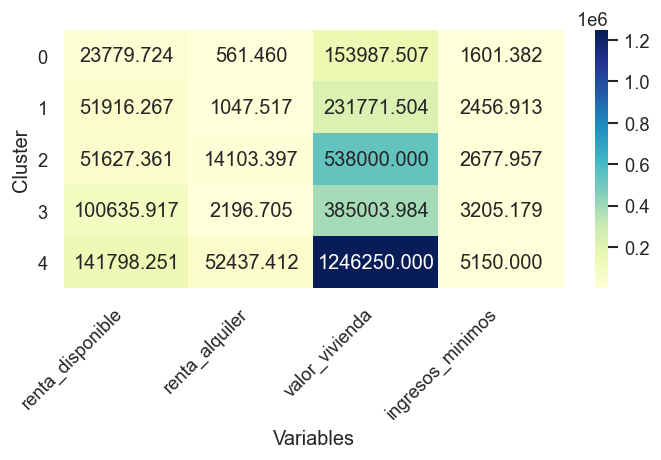

<Figure size 720x480 with 0 Axes>

In [140]:
visualization.plot_heatmap(algorithms[0].instances[0])

##### Birch

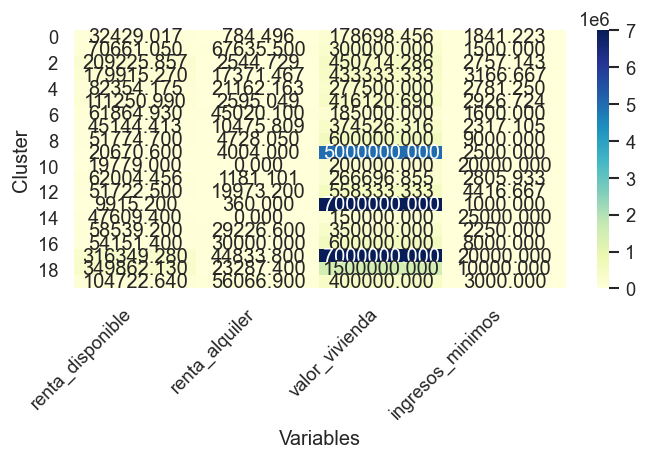

<Figure size 720x480 with 0 Axes>

In [141]:
visualization.plot_heatmap(algorithms[1].instances[0])

##### DBSCAN

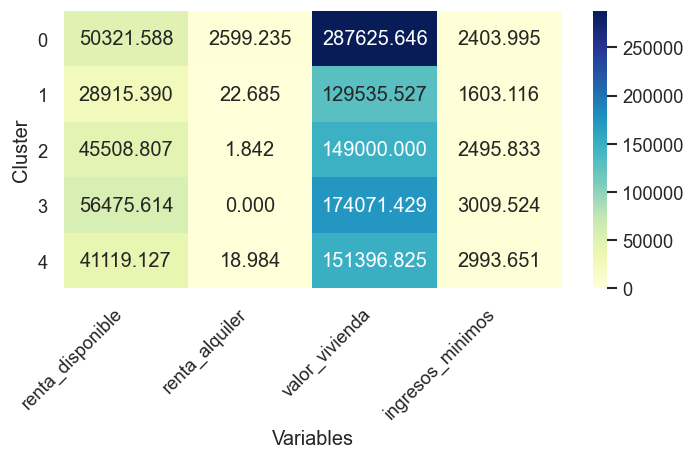

<Figure size 720x480 with 0 Axes>

In [142]:
visualization.plot_heatmap(algorithms[2].instances[0])

##### Mean Shift

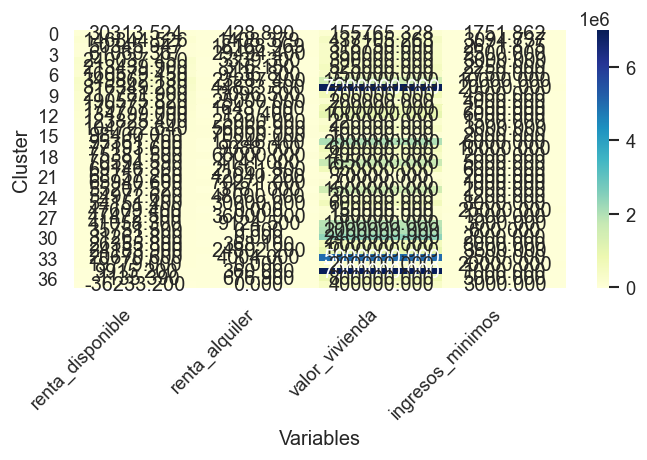

<Figure size 720x480 with 0 Axes>

In [143]:
visualization.plot_heatmap(algorithms[3].instances[0])

##### Ward

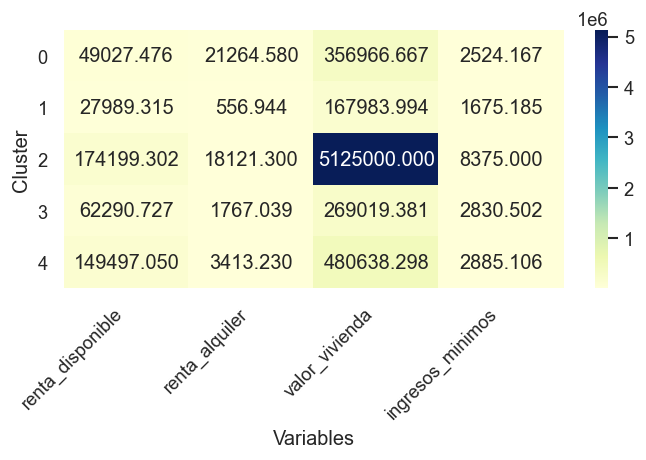

<Figure size 720x480 with 0 Axes>

In [144]:
visualization.plot_heatmap(algorithms[4].instances[0])

#### Cluster sizes

##### K-Means

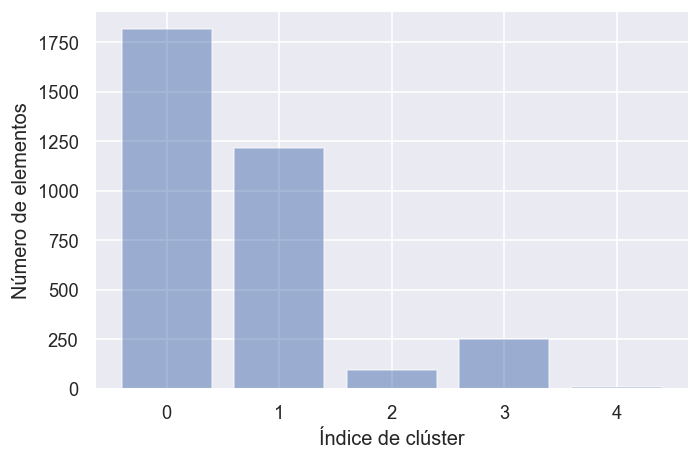

In [145]:
visualization.plot_cluster_sizes(algorithms[0].instances[0])

##### Birch

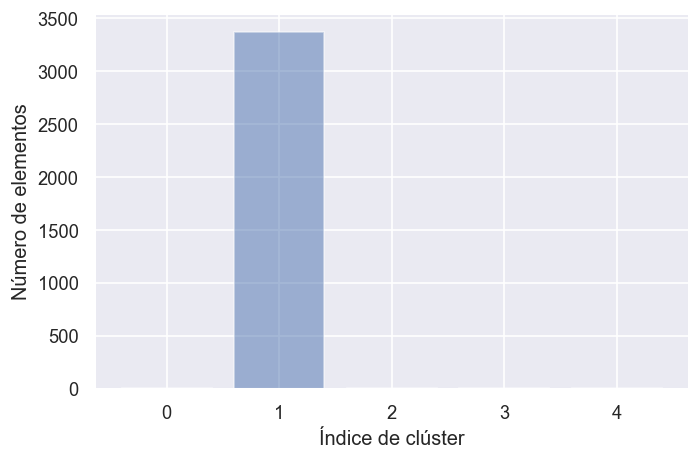

In [146]:
visualization.plot_cluster_sizes(algorithms[1].instances[0])

##### DBSCAN

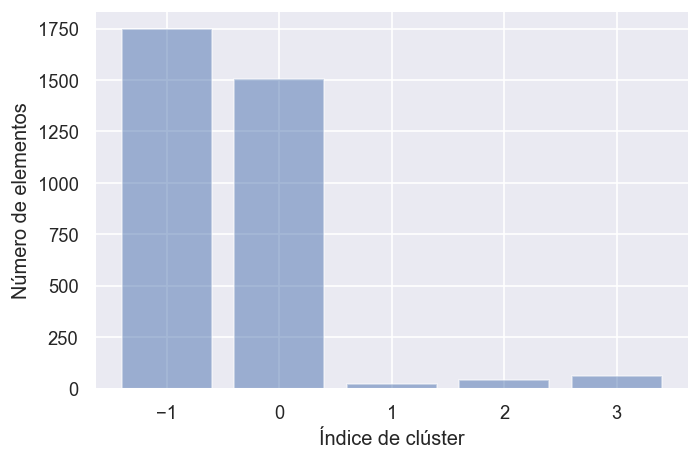

In [147]:
visualization.plot_cluster_sizes(algorithms[2].instances[0])

##### Mean Shift

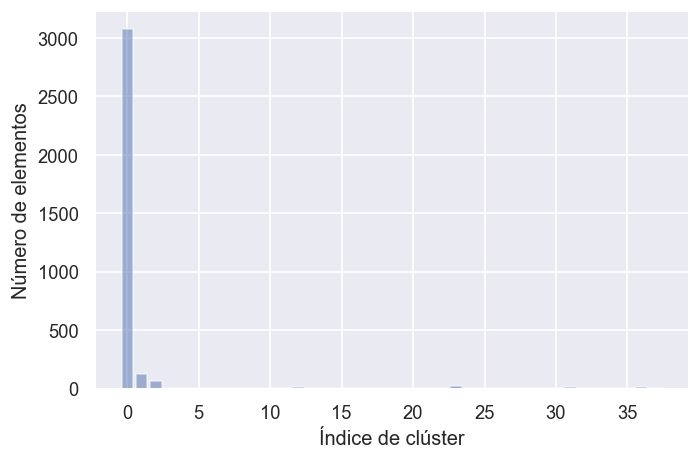

In [148]:
visualization.plot_cluster_sizes(algorithms[3].instances[0])

##### Ward

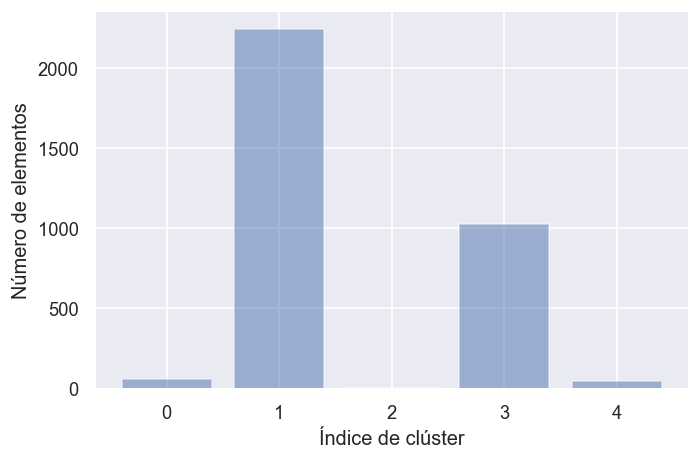

In [149]:
visualization.plot_cluster_sizes(algorithms[4].instances[0])

#### Scatter matrix

##### K-Means

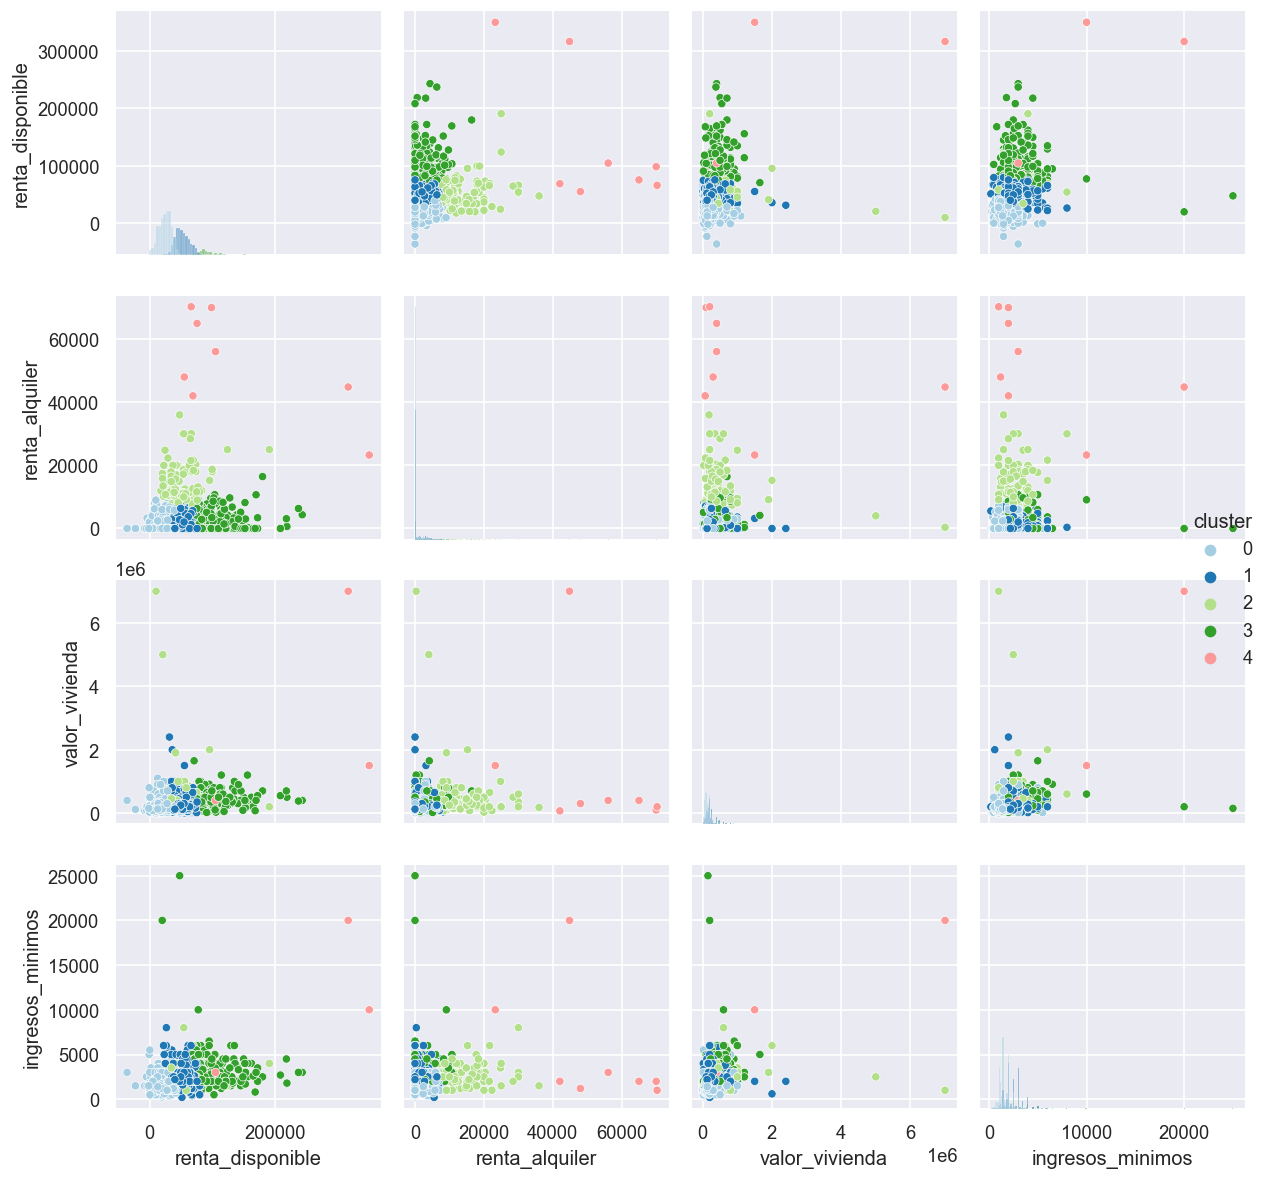

<Figure size 720x480 with 0 Axes>

In [150]:
visualization.plot_scatter_matrix(algorithms[0].instances[0])

##### Birch

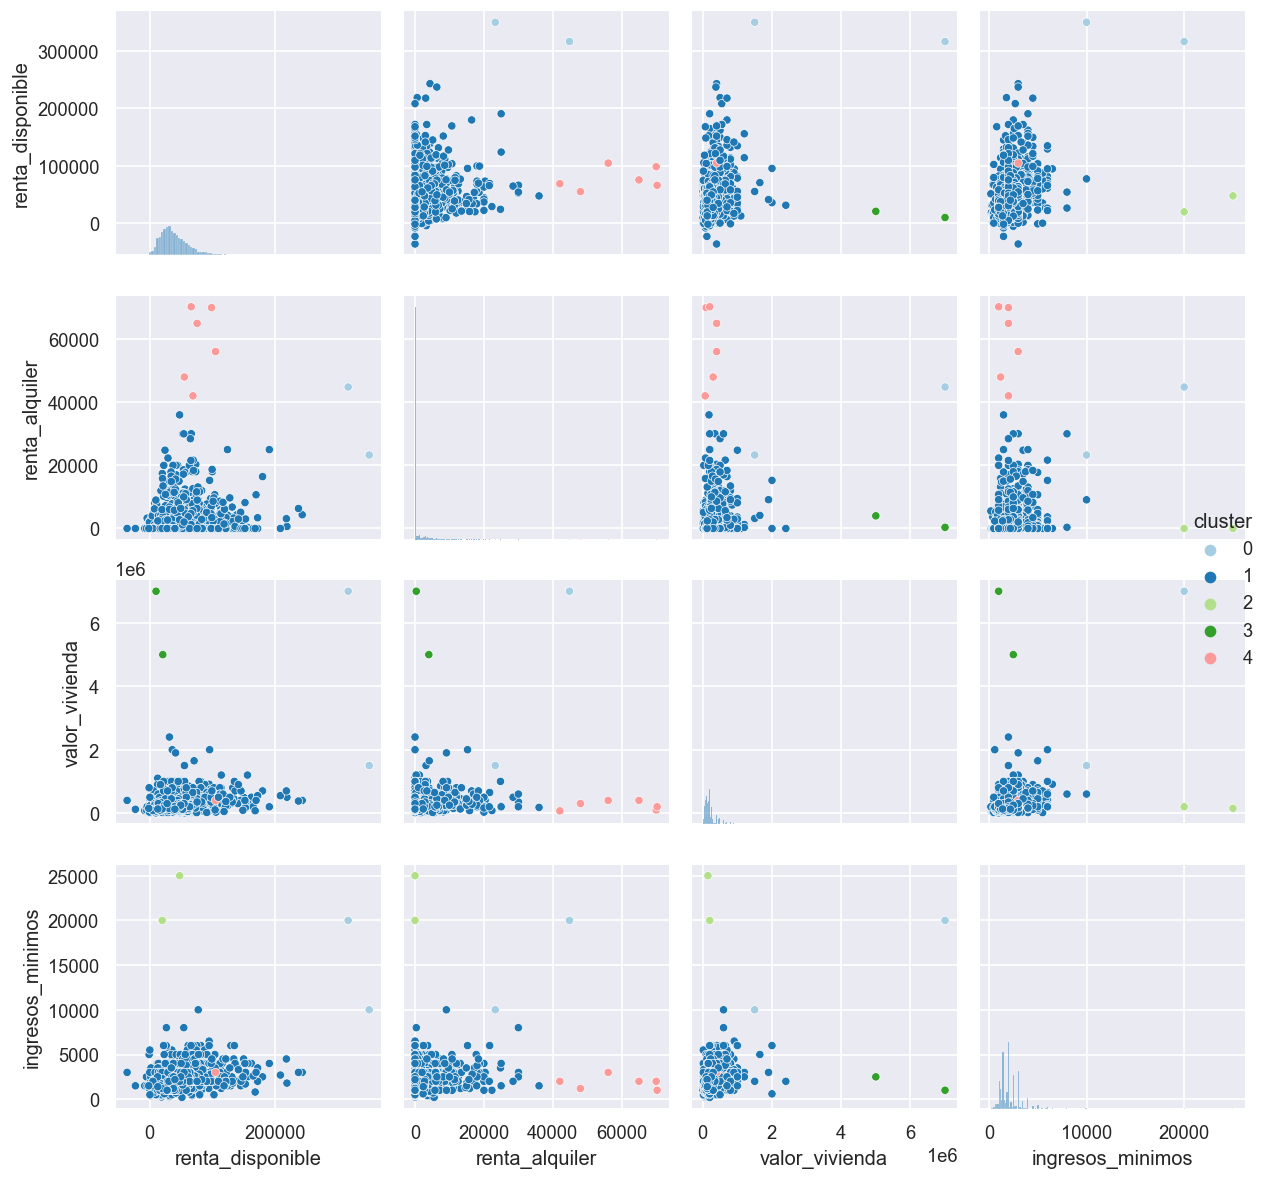

<Figure size 720x480 with 0 Axes>

In [151]:
visualization.plot_scatter_matrix(algorithms[1].instances[0])

##### DBSCAN

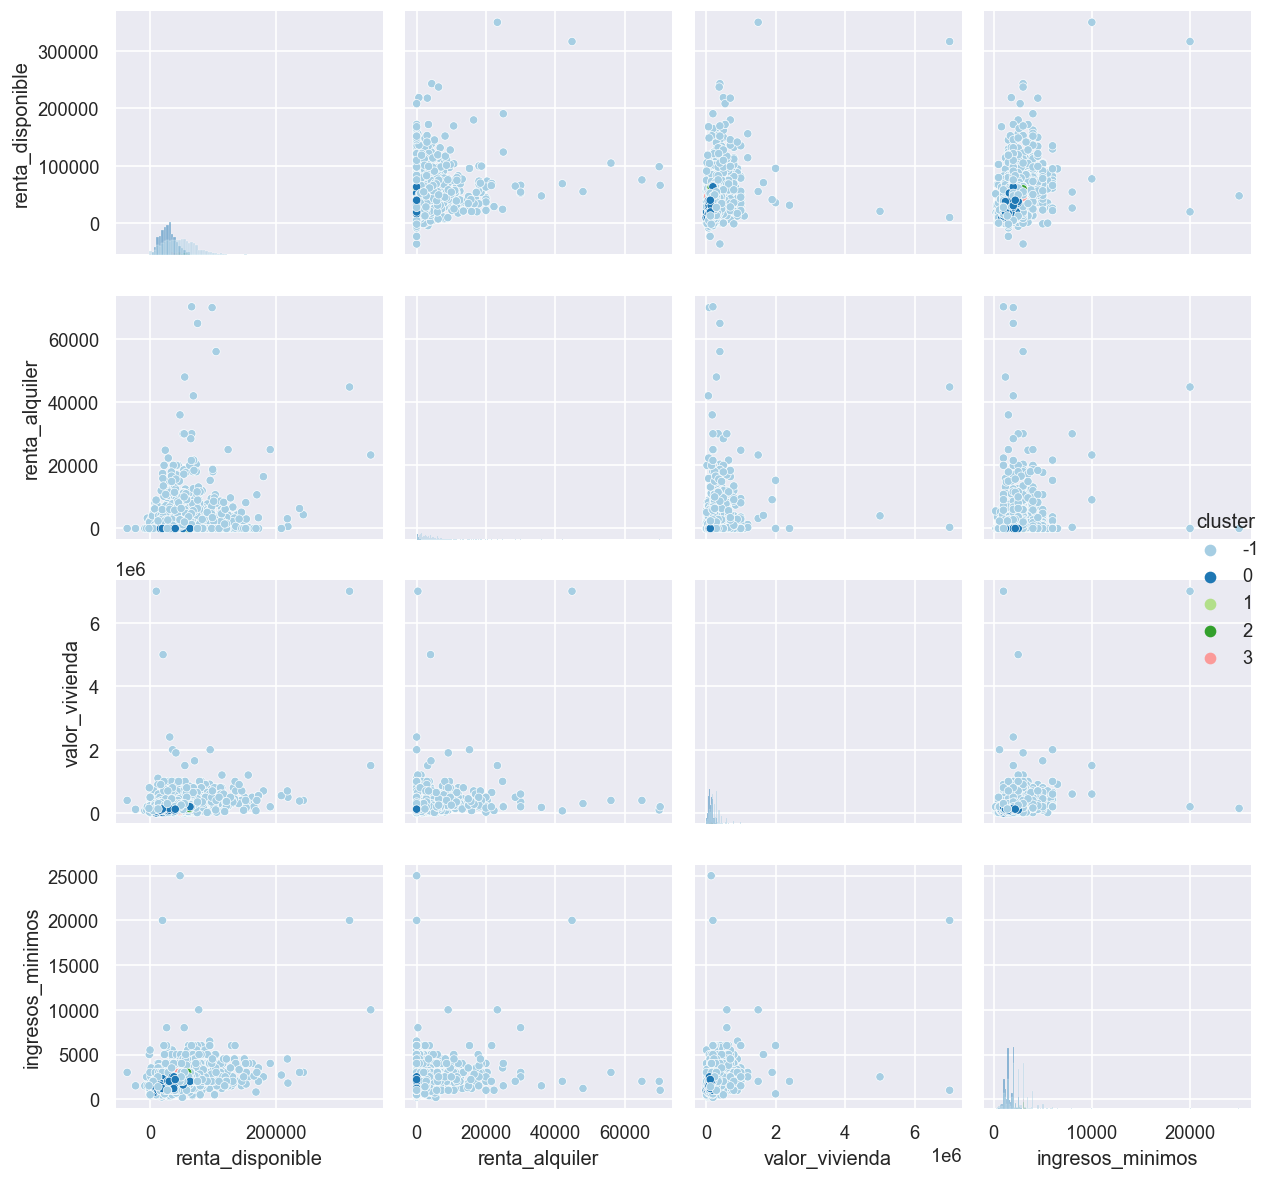

<Figure size 720x480 with 0 Axes>

In [152]:
visualization.plot_scatter_matrix(algorithms[2].instances[0])

##### Mean Shift

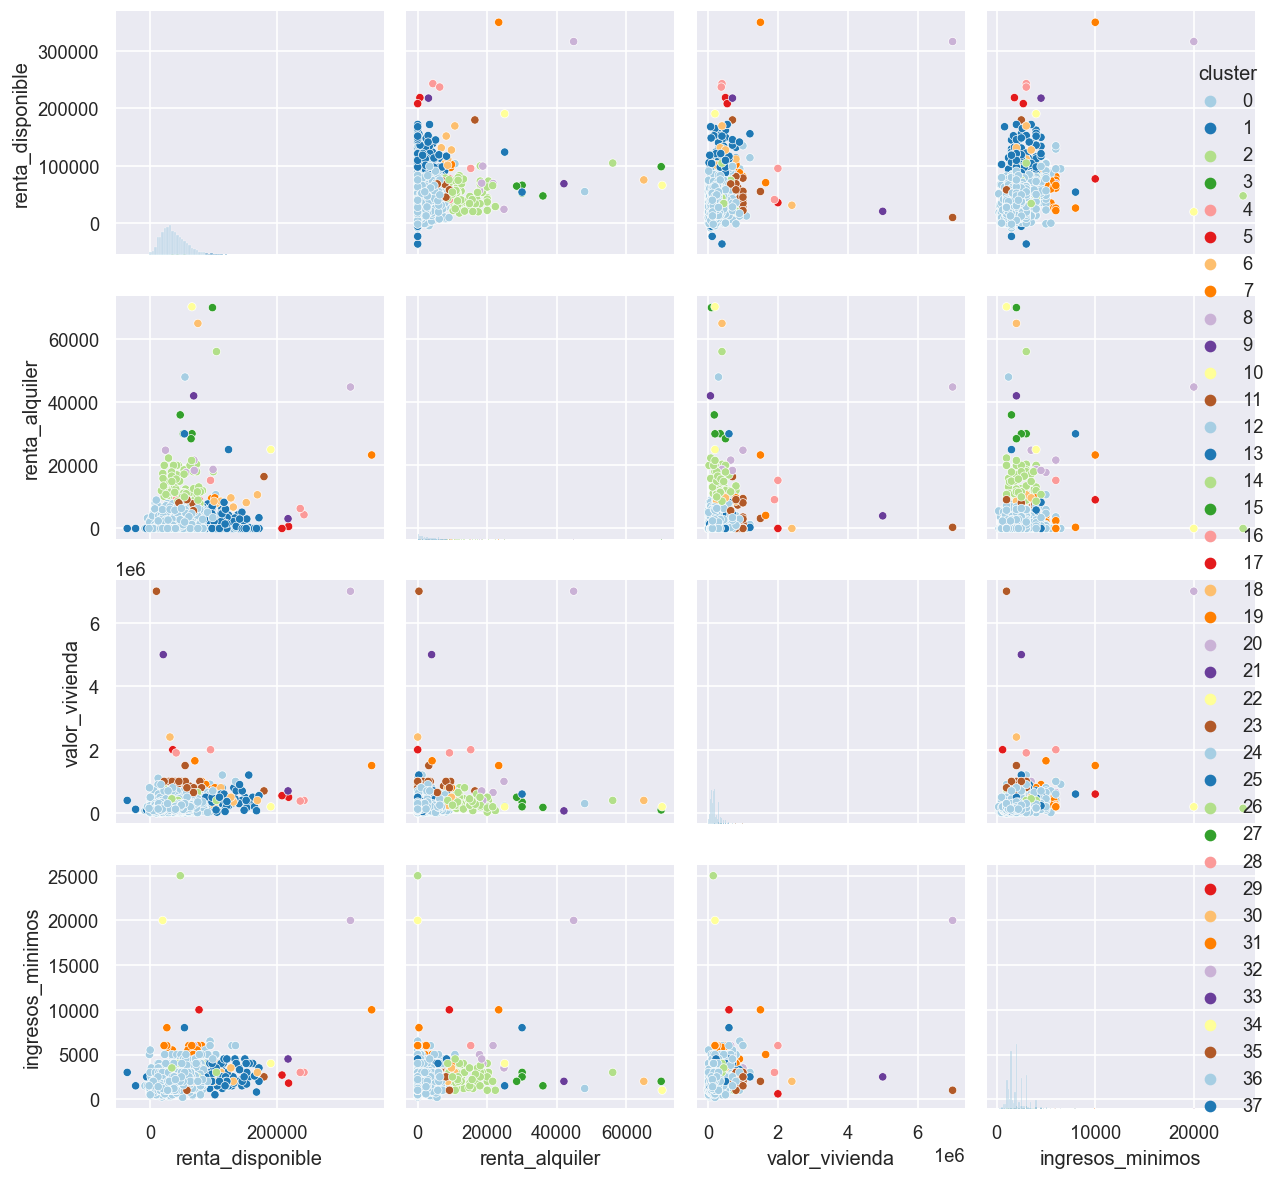

<Figure size 720x480 with 0 Axes>

In [153]:
visualization.plot_scatter_matrix(algorithms[3].instances[0])

##### Ward

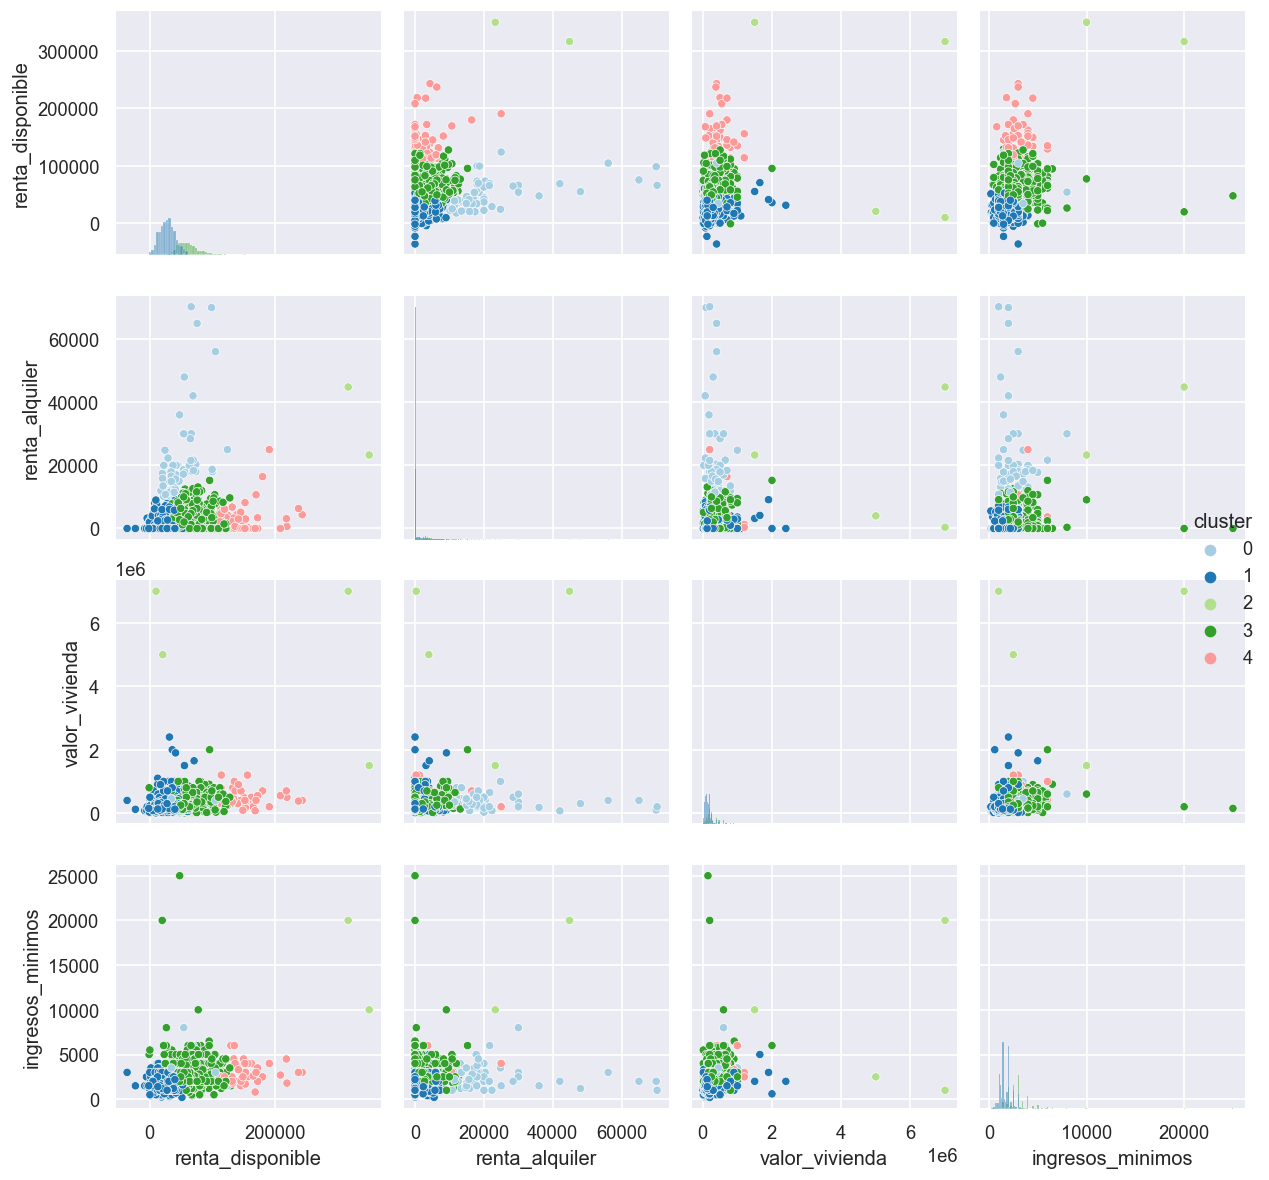

<Figure size 720x480 with 0 Axes>

In [154]:
visualization.plot_scatter_matrix(algorithms[4].instances[0])

#### Boxplot

##### K-Means

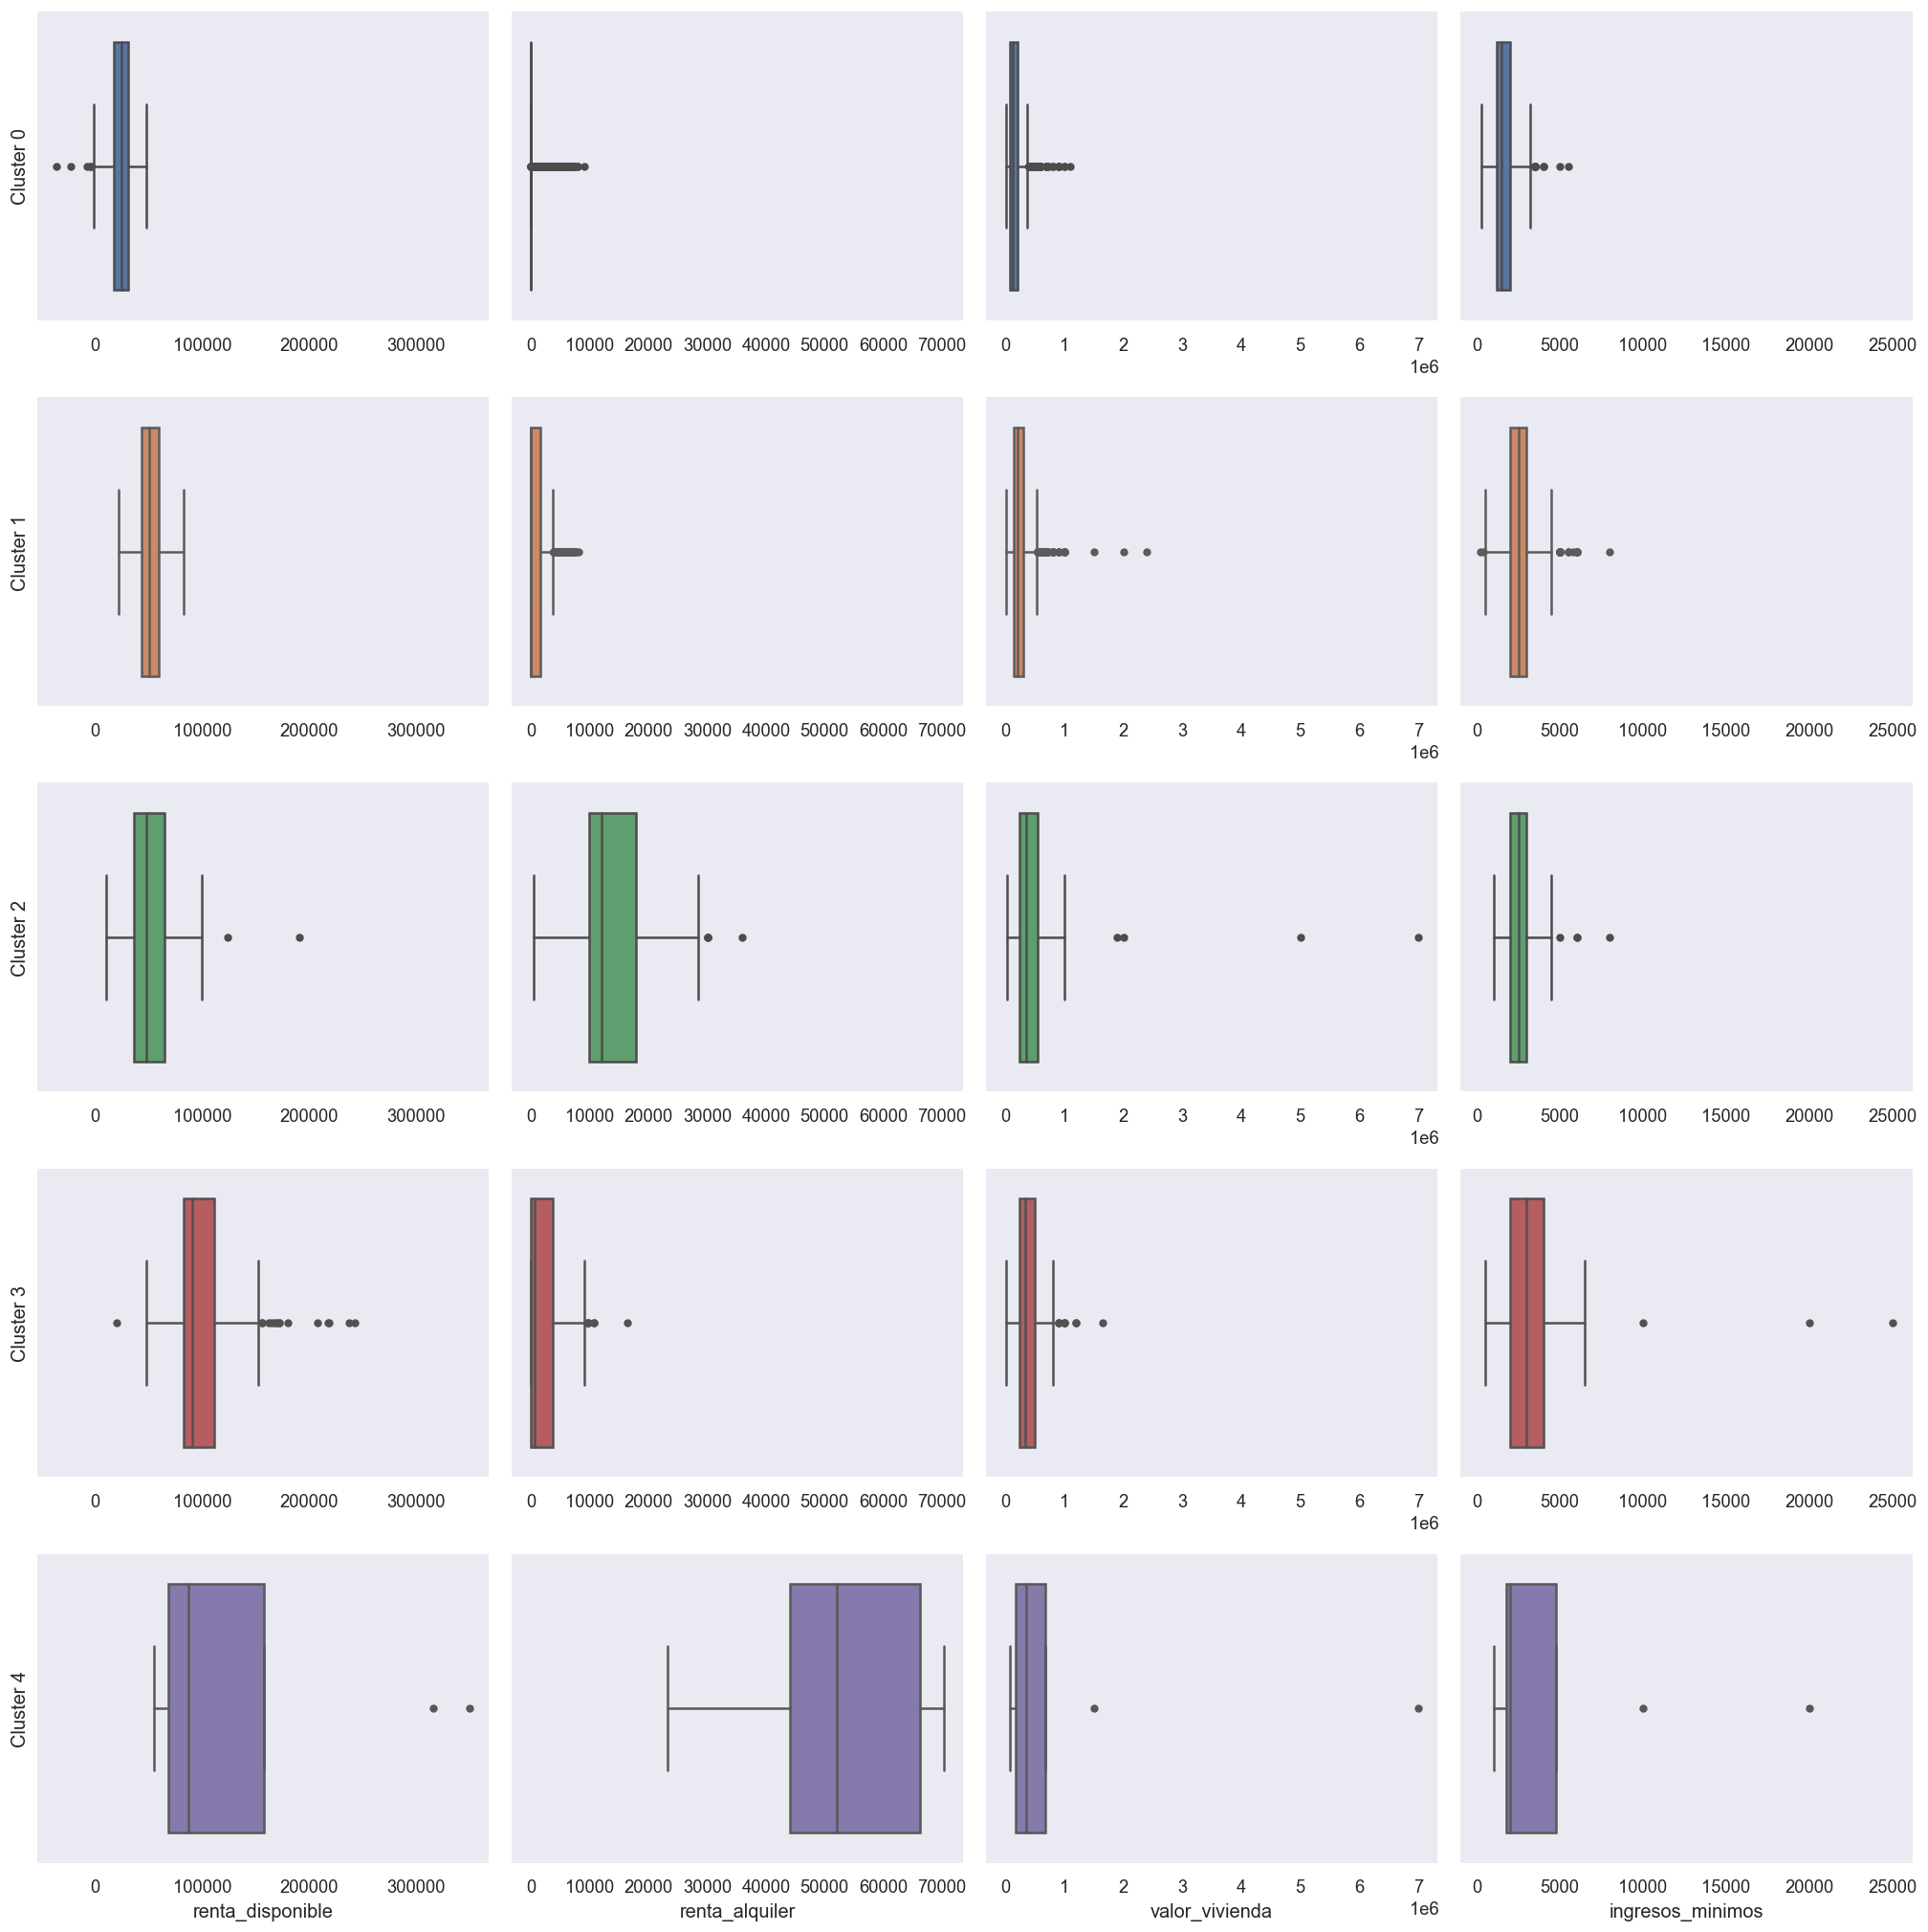

<Figure size 720x480 with 0 Axes>

In [155]:
visualization.plot_boxplot(algorithms[0].instances[0])

##### Birch

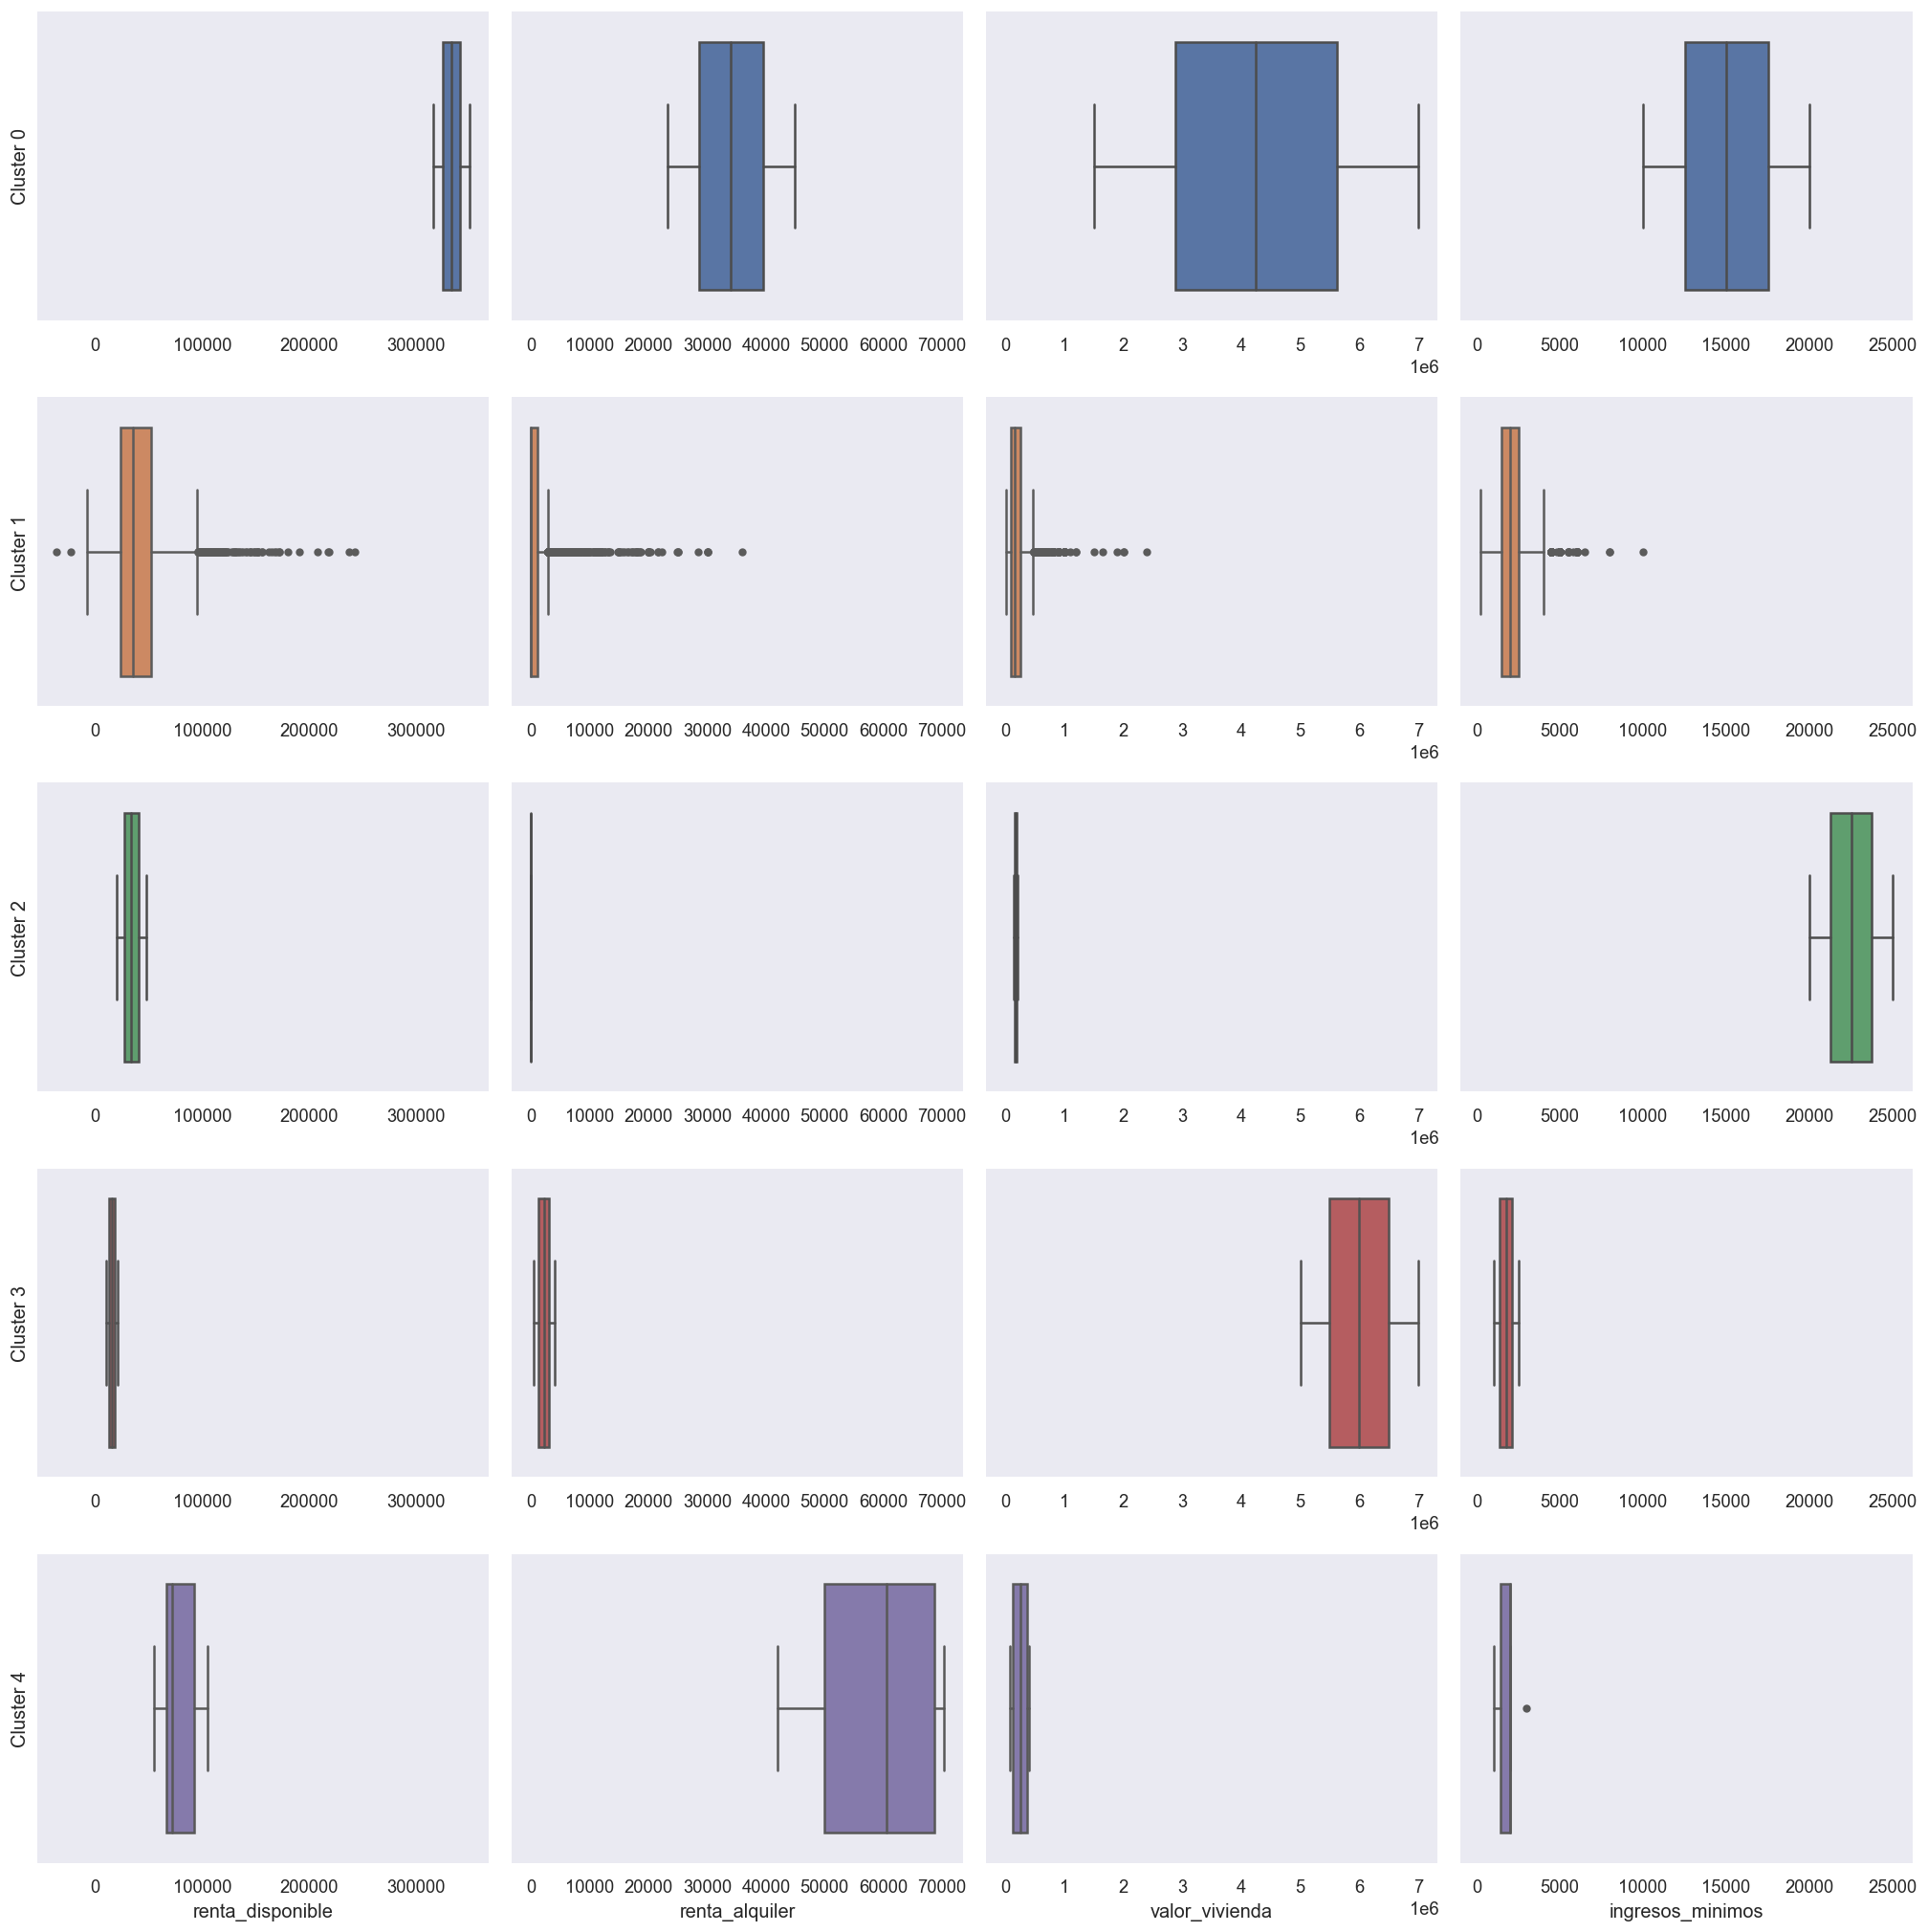

<Figure size 720x480 with 0 Axes>

In [156]:
visualization.plot_boxplot(algorithms[1].instances[0])

##### DBSCAN

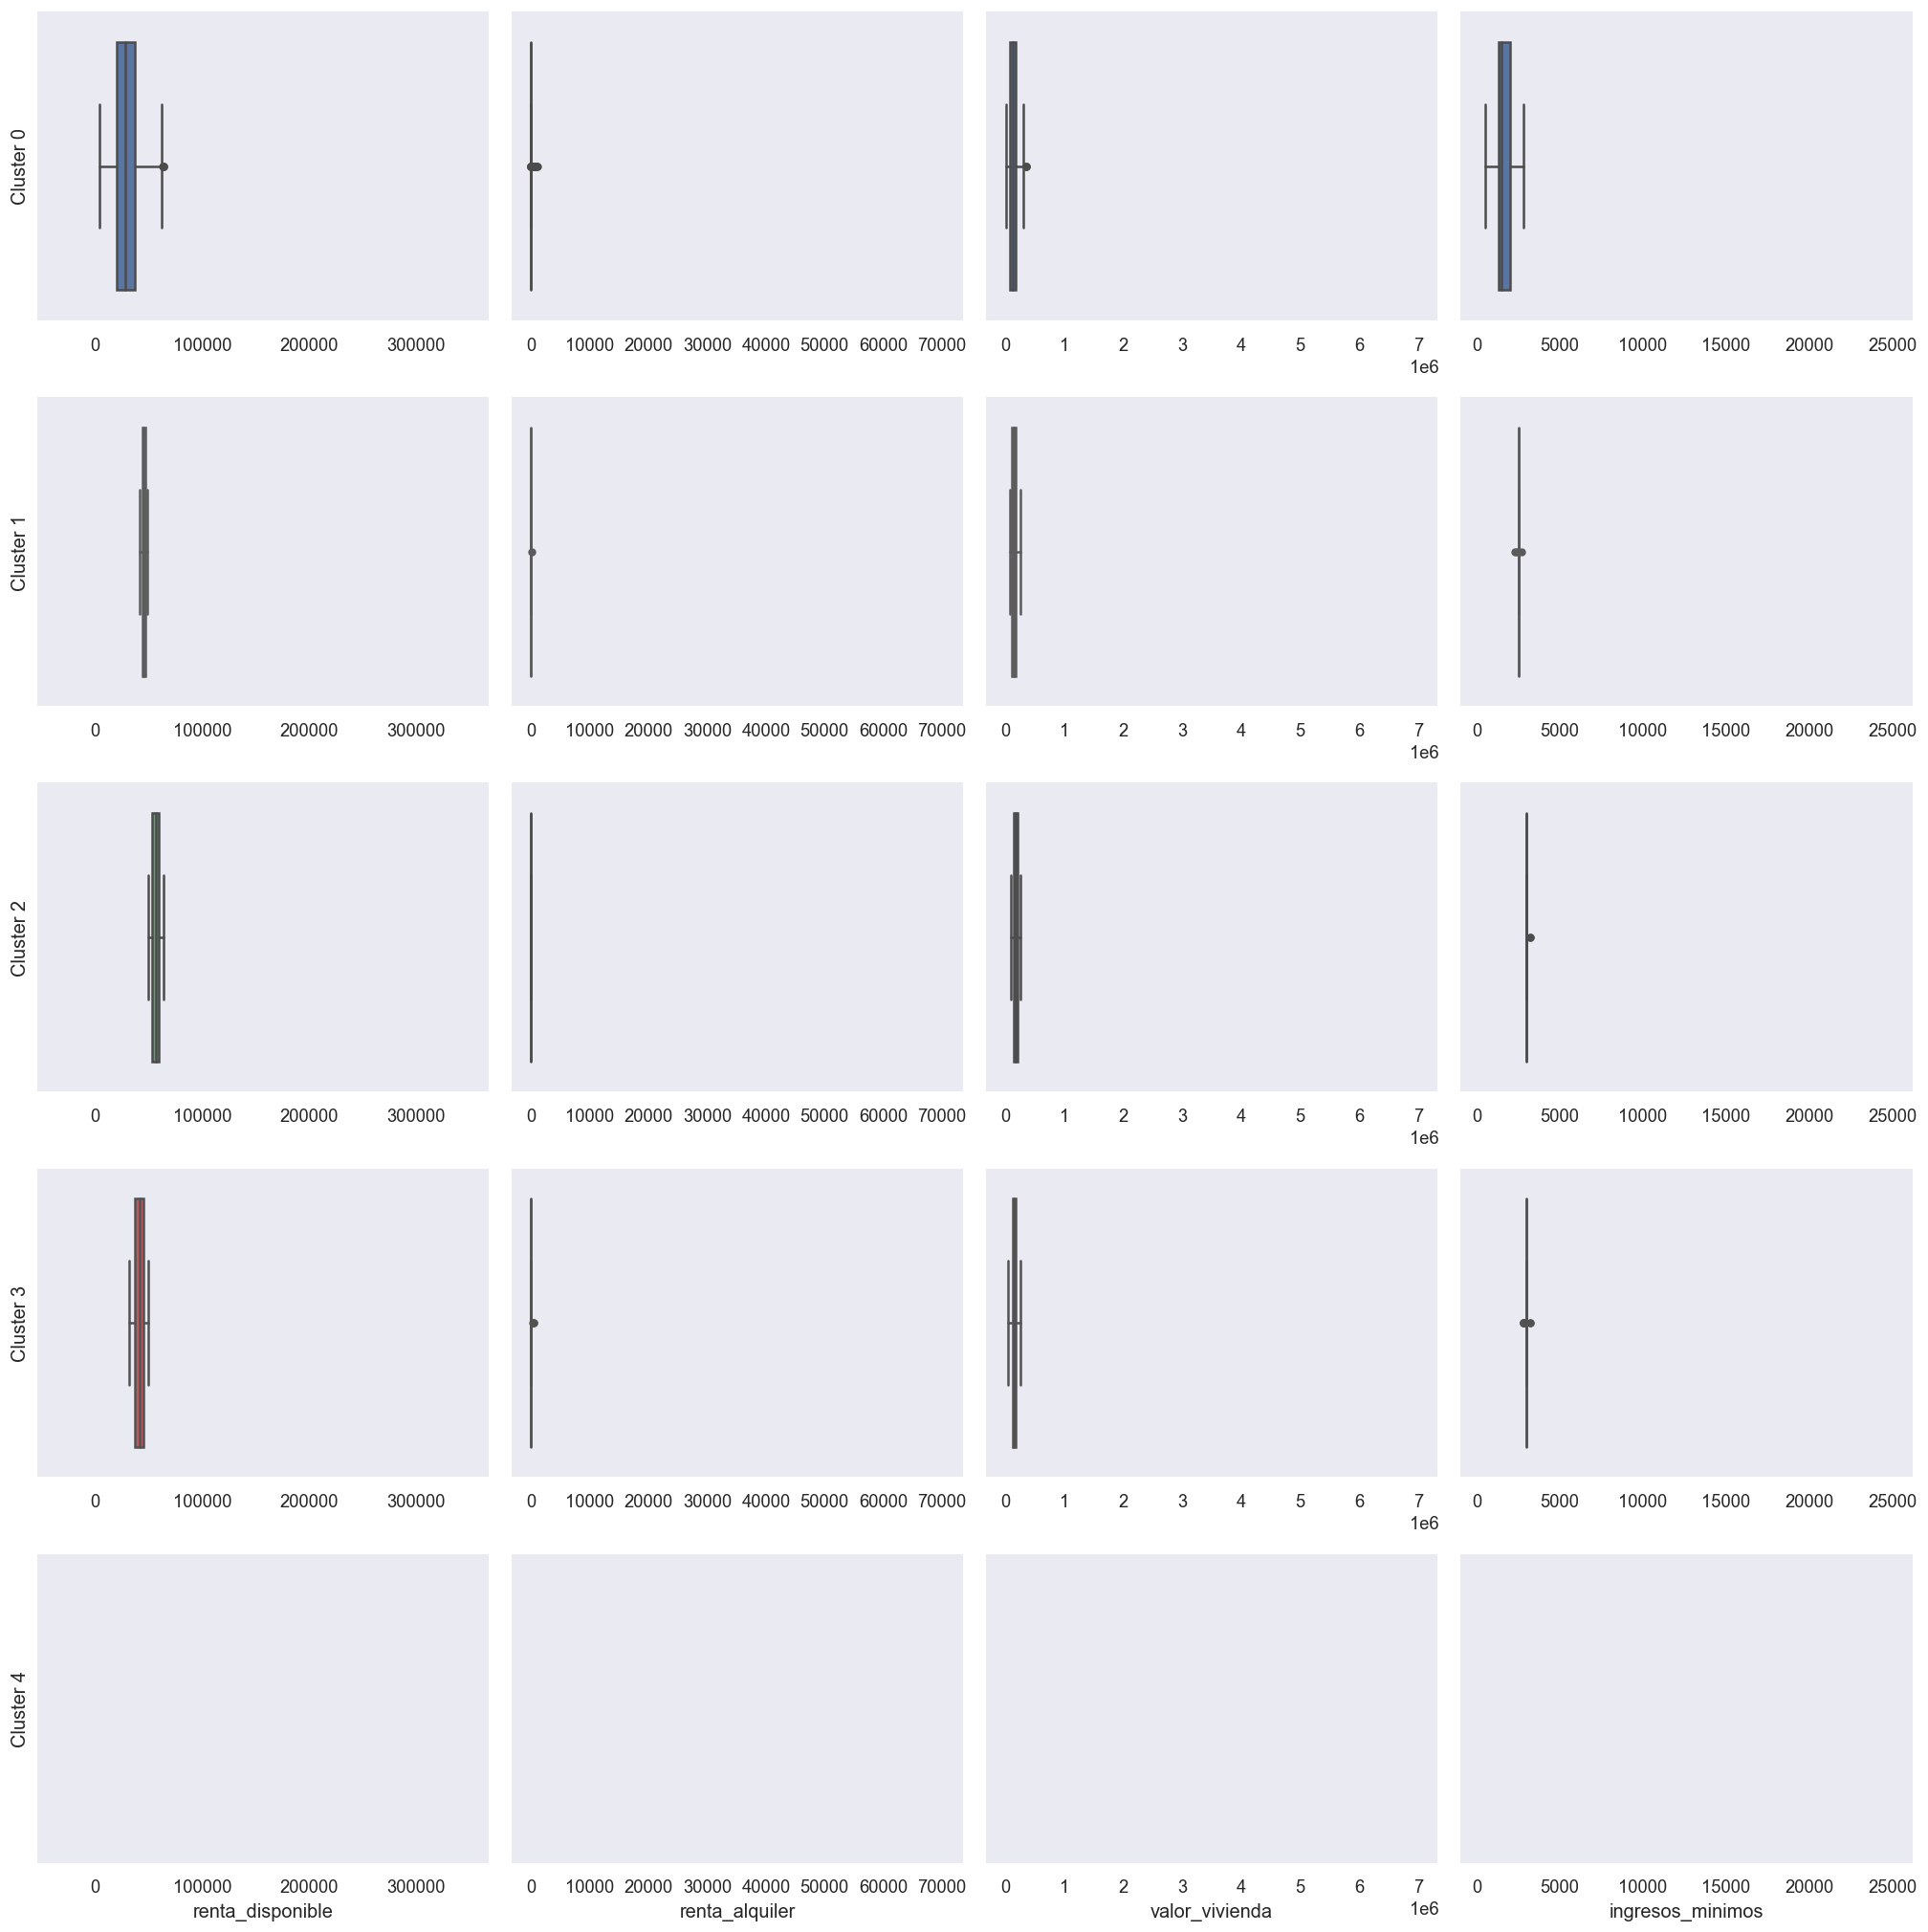

<Figure size 720x480 with 0 Axes>

In [157]:
visualization.plot_boxplot(algorithms[2].instances[0])

##### Mean Shift

C:\Users\CF\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.canvas.print_figure(bytes_io, **kw)


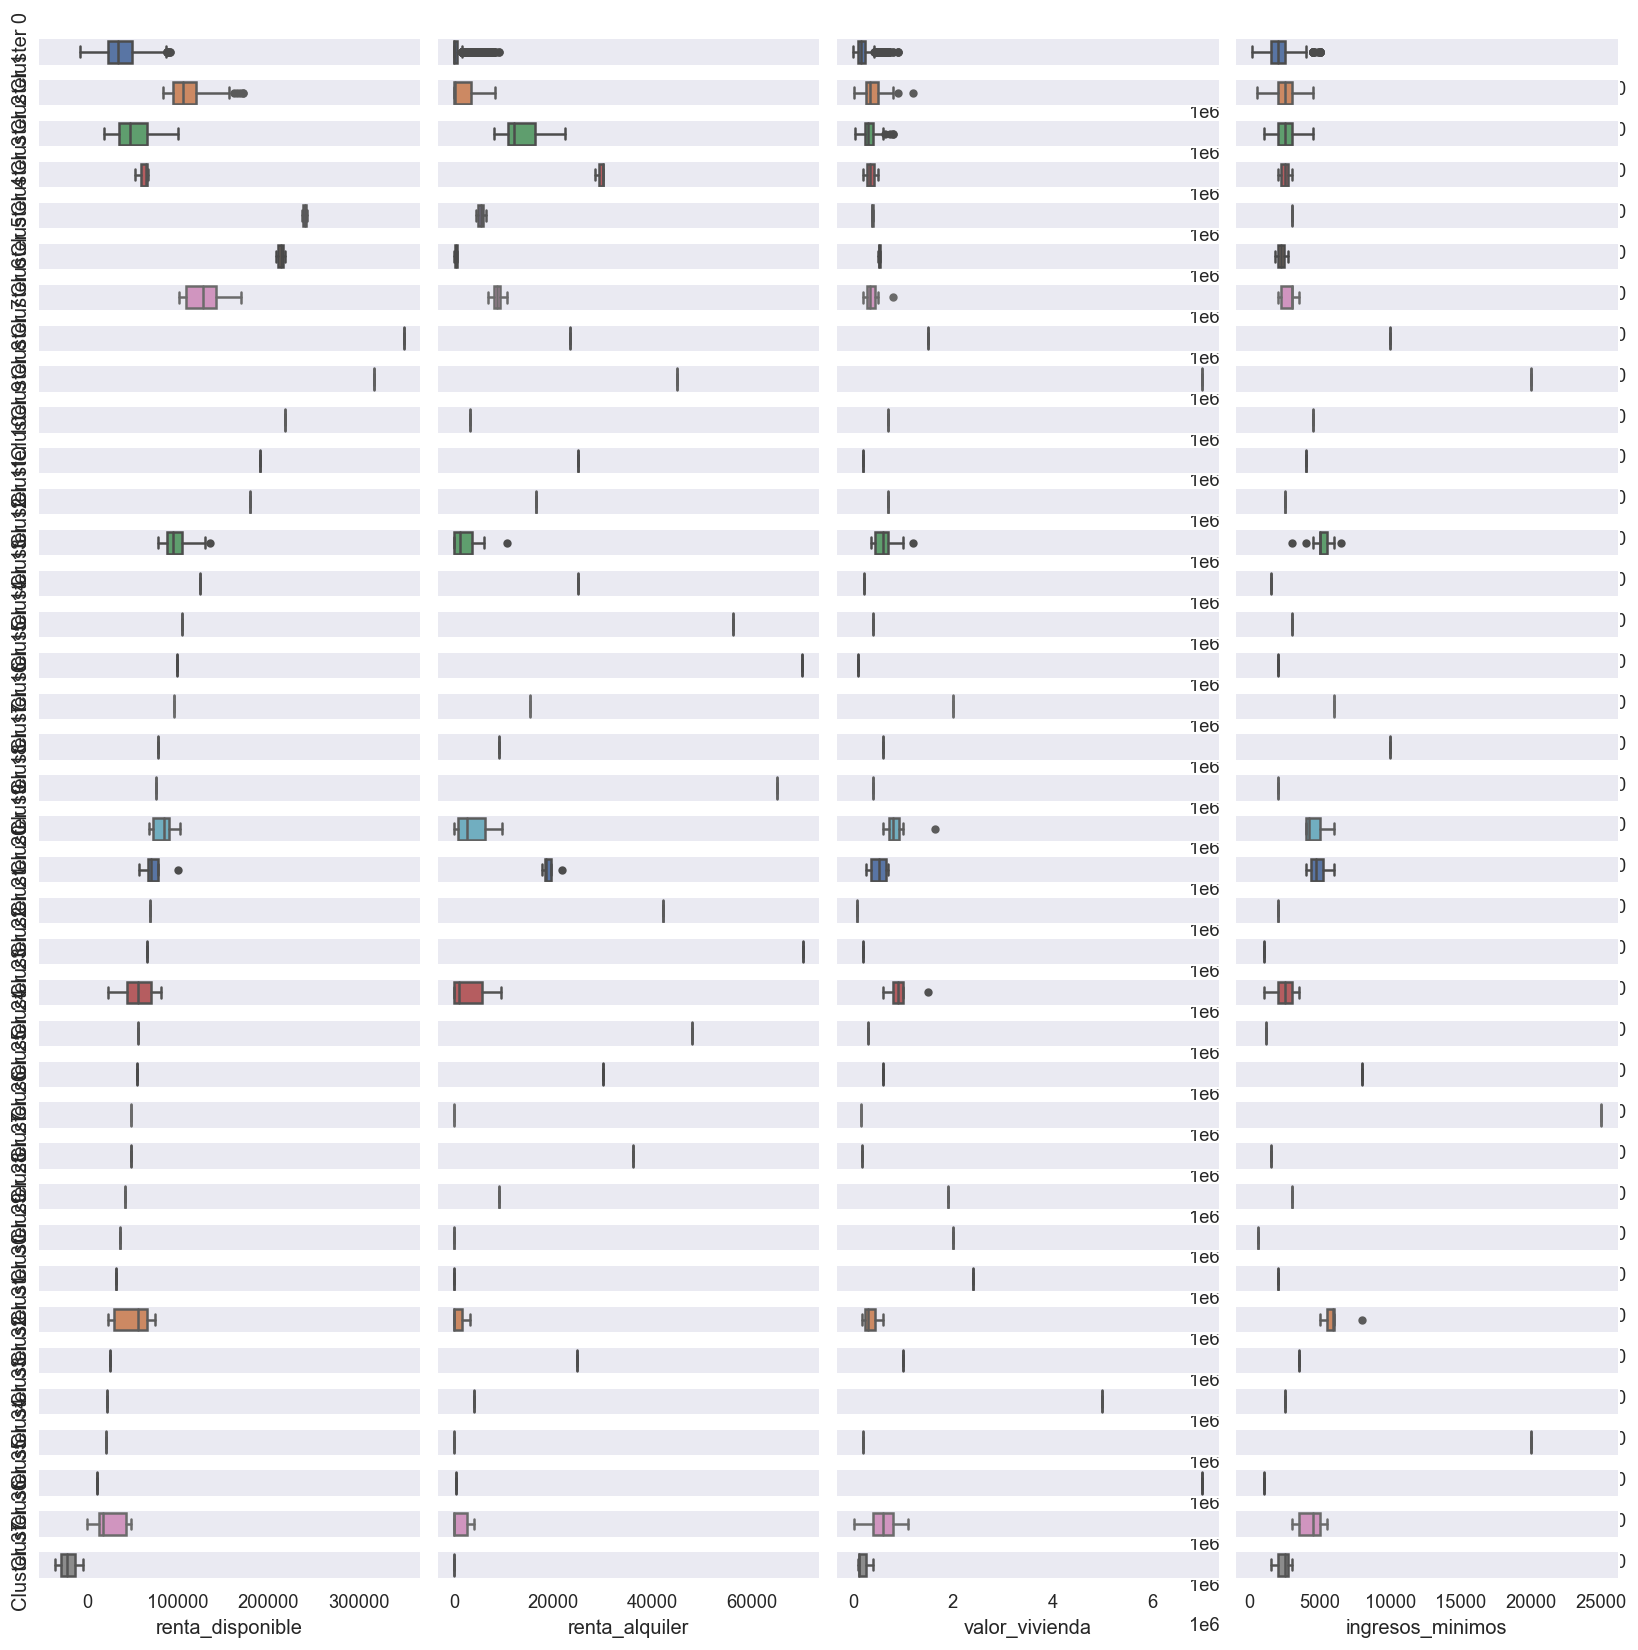

<Figure size 720x480 with 0 Axes>

In [158]:
visualization.plot_boxplot(algorithms[3].instances[0])

##### Ward

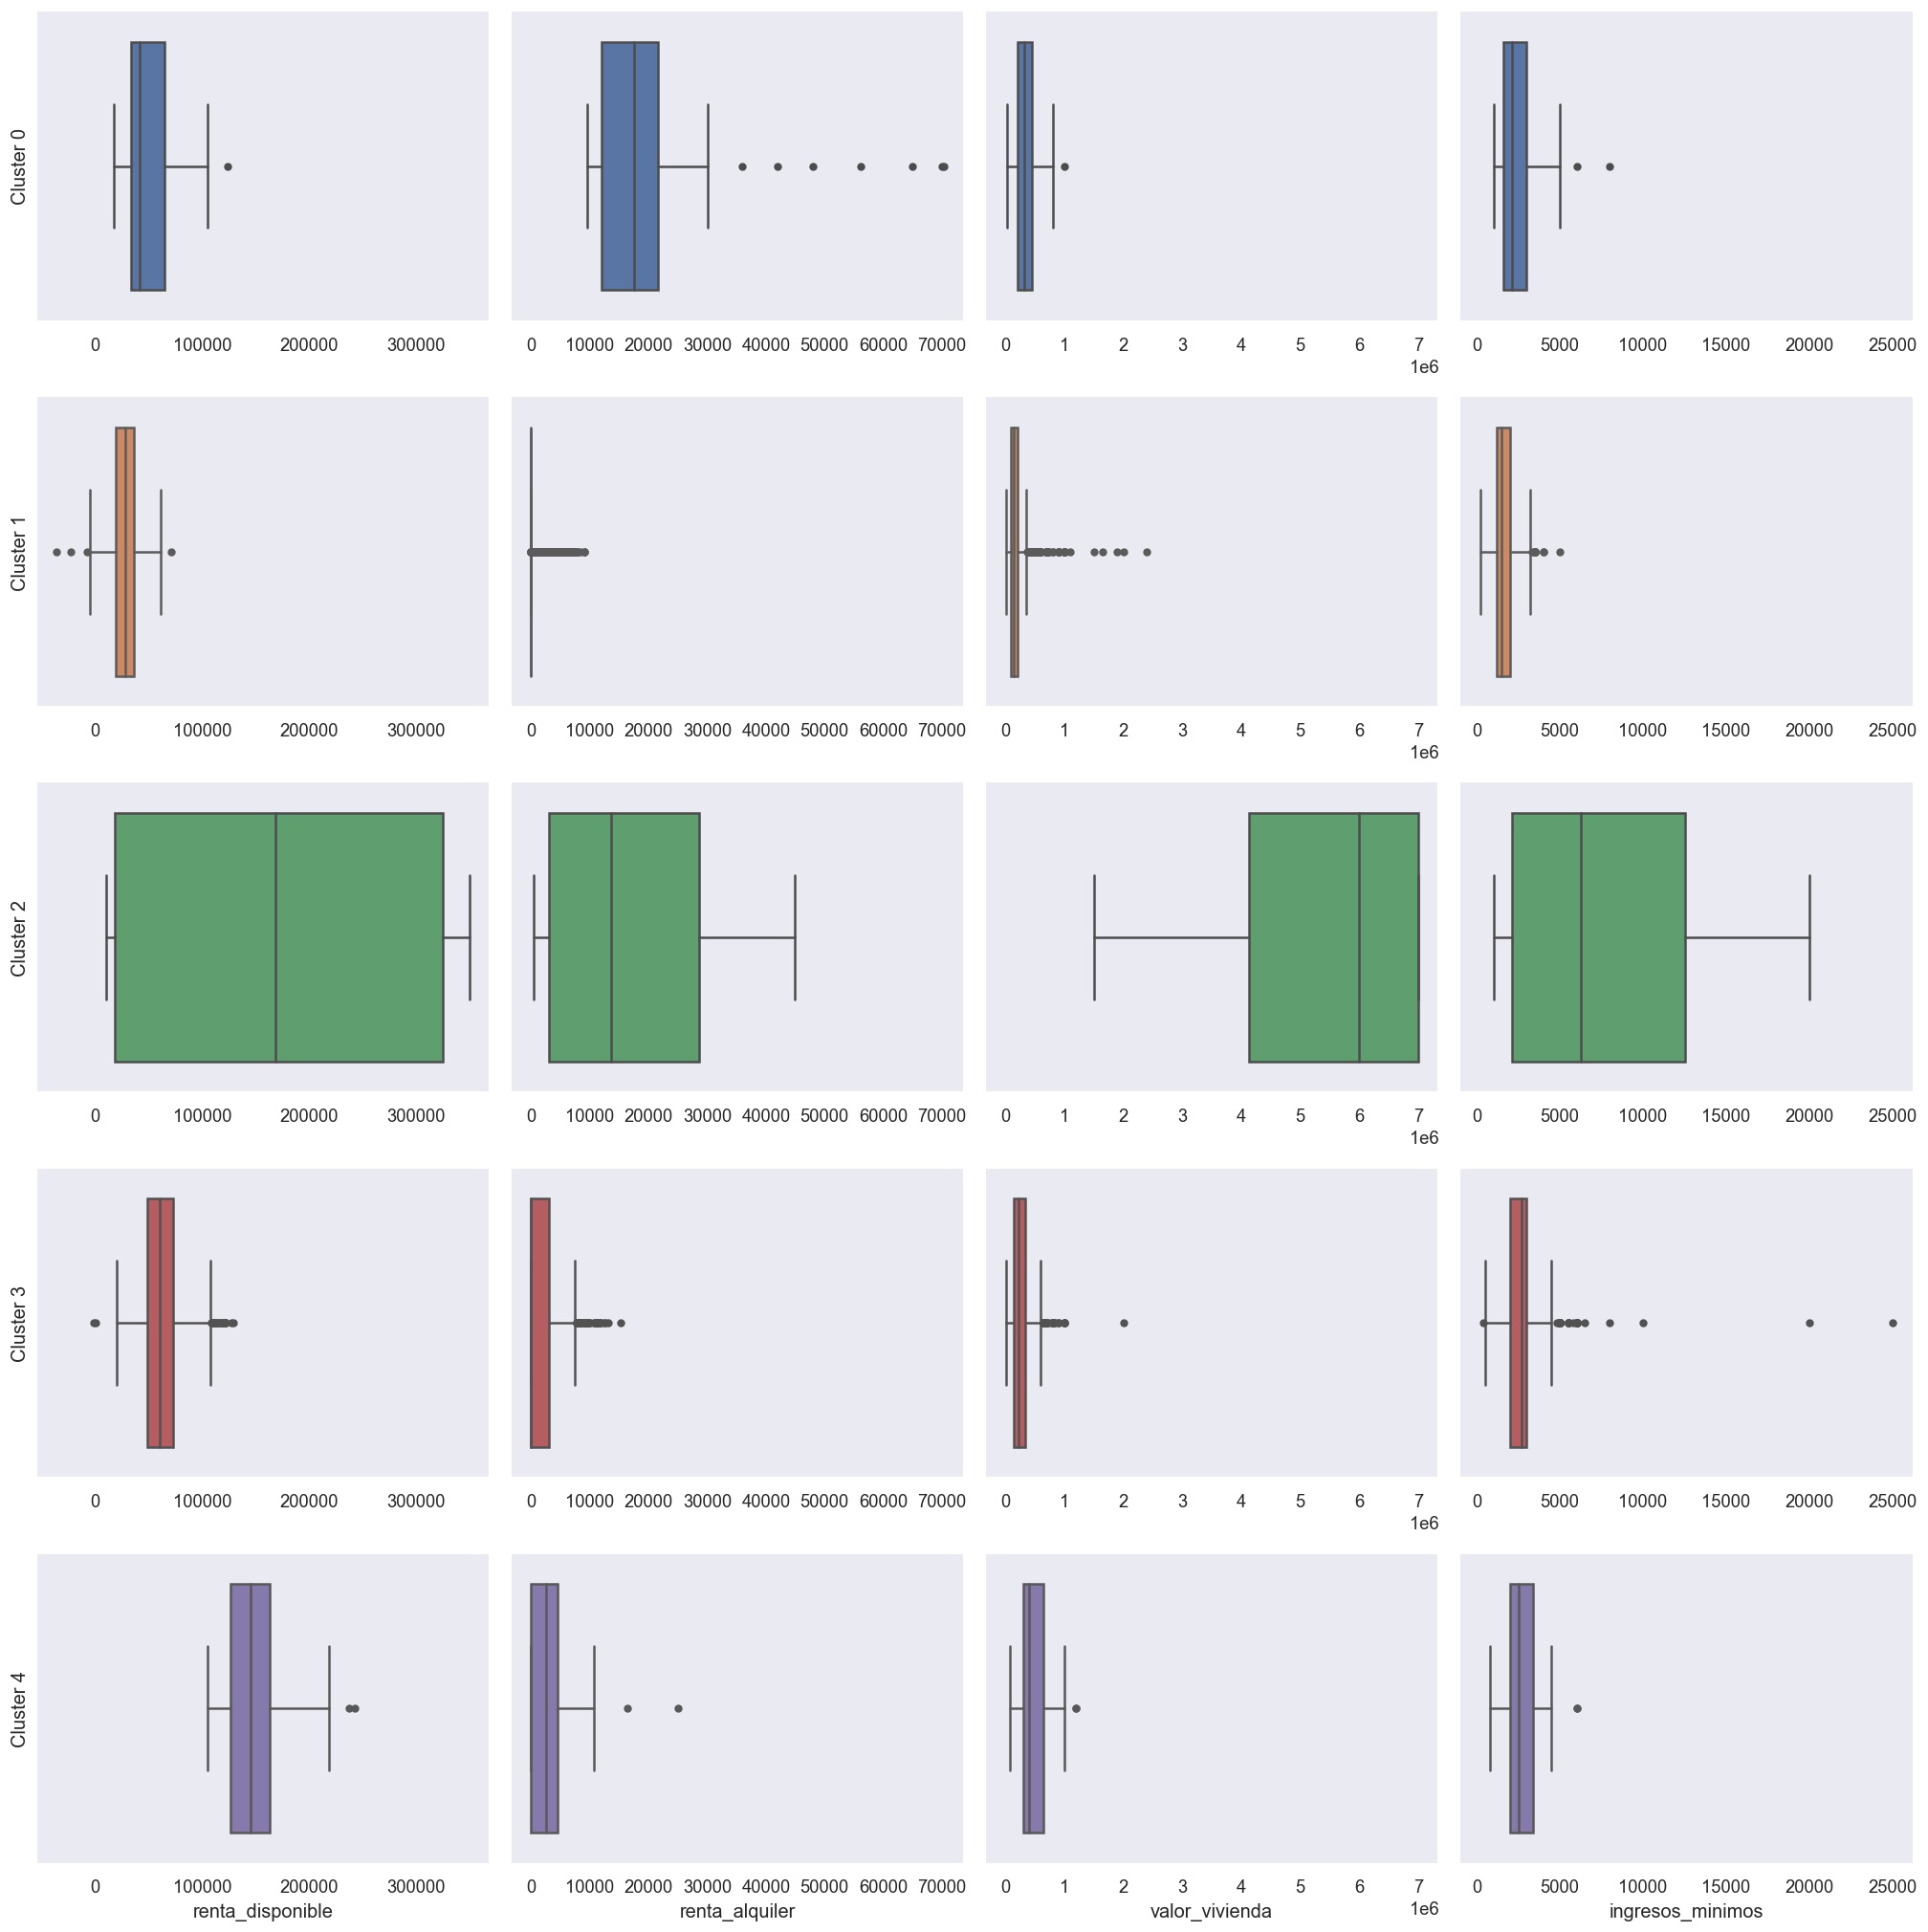

<Figure size 720x480 with 0 Axes>

In [159]:
visualization.plot_boxplot(algorithms[4].instances[0])

#### Dendrograma

##### Ward

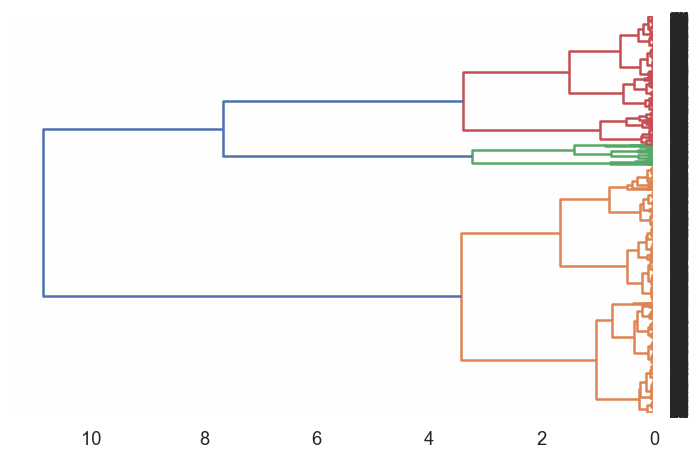

<Figure size 720x480 with 0 Axes>

In [45]:
visualization.plot_dendrogram(algorithms[4].instances[0])

C:\Users\CF\anaconda3\lib\site-packages\seaborn\matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


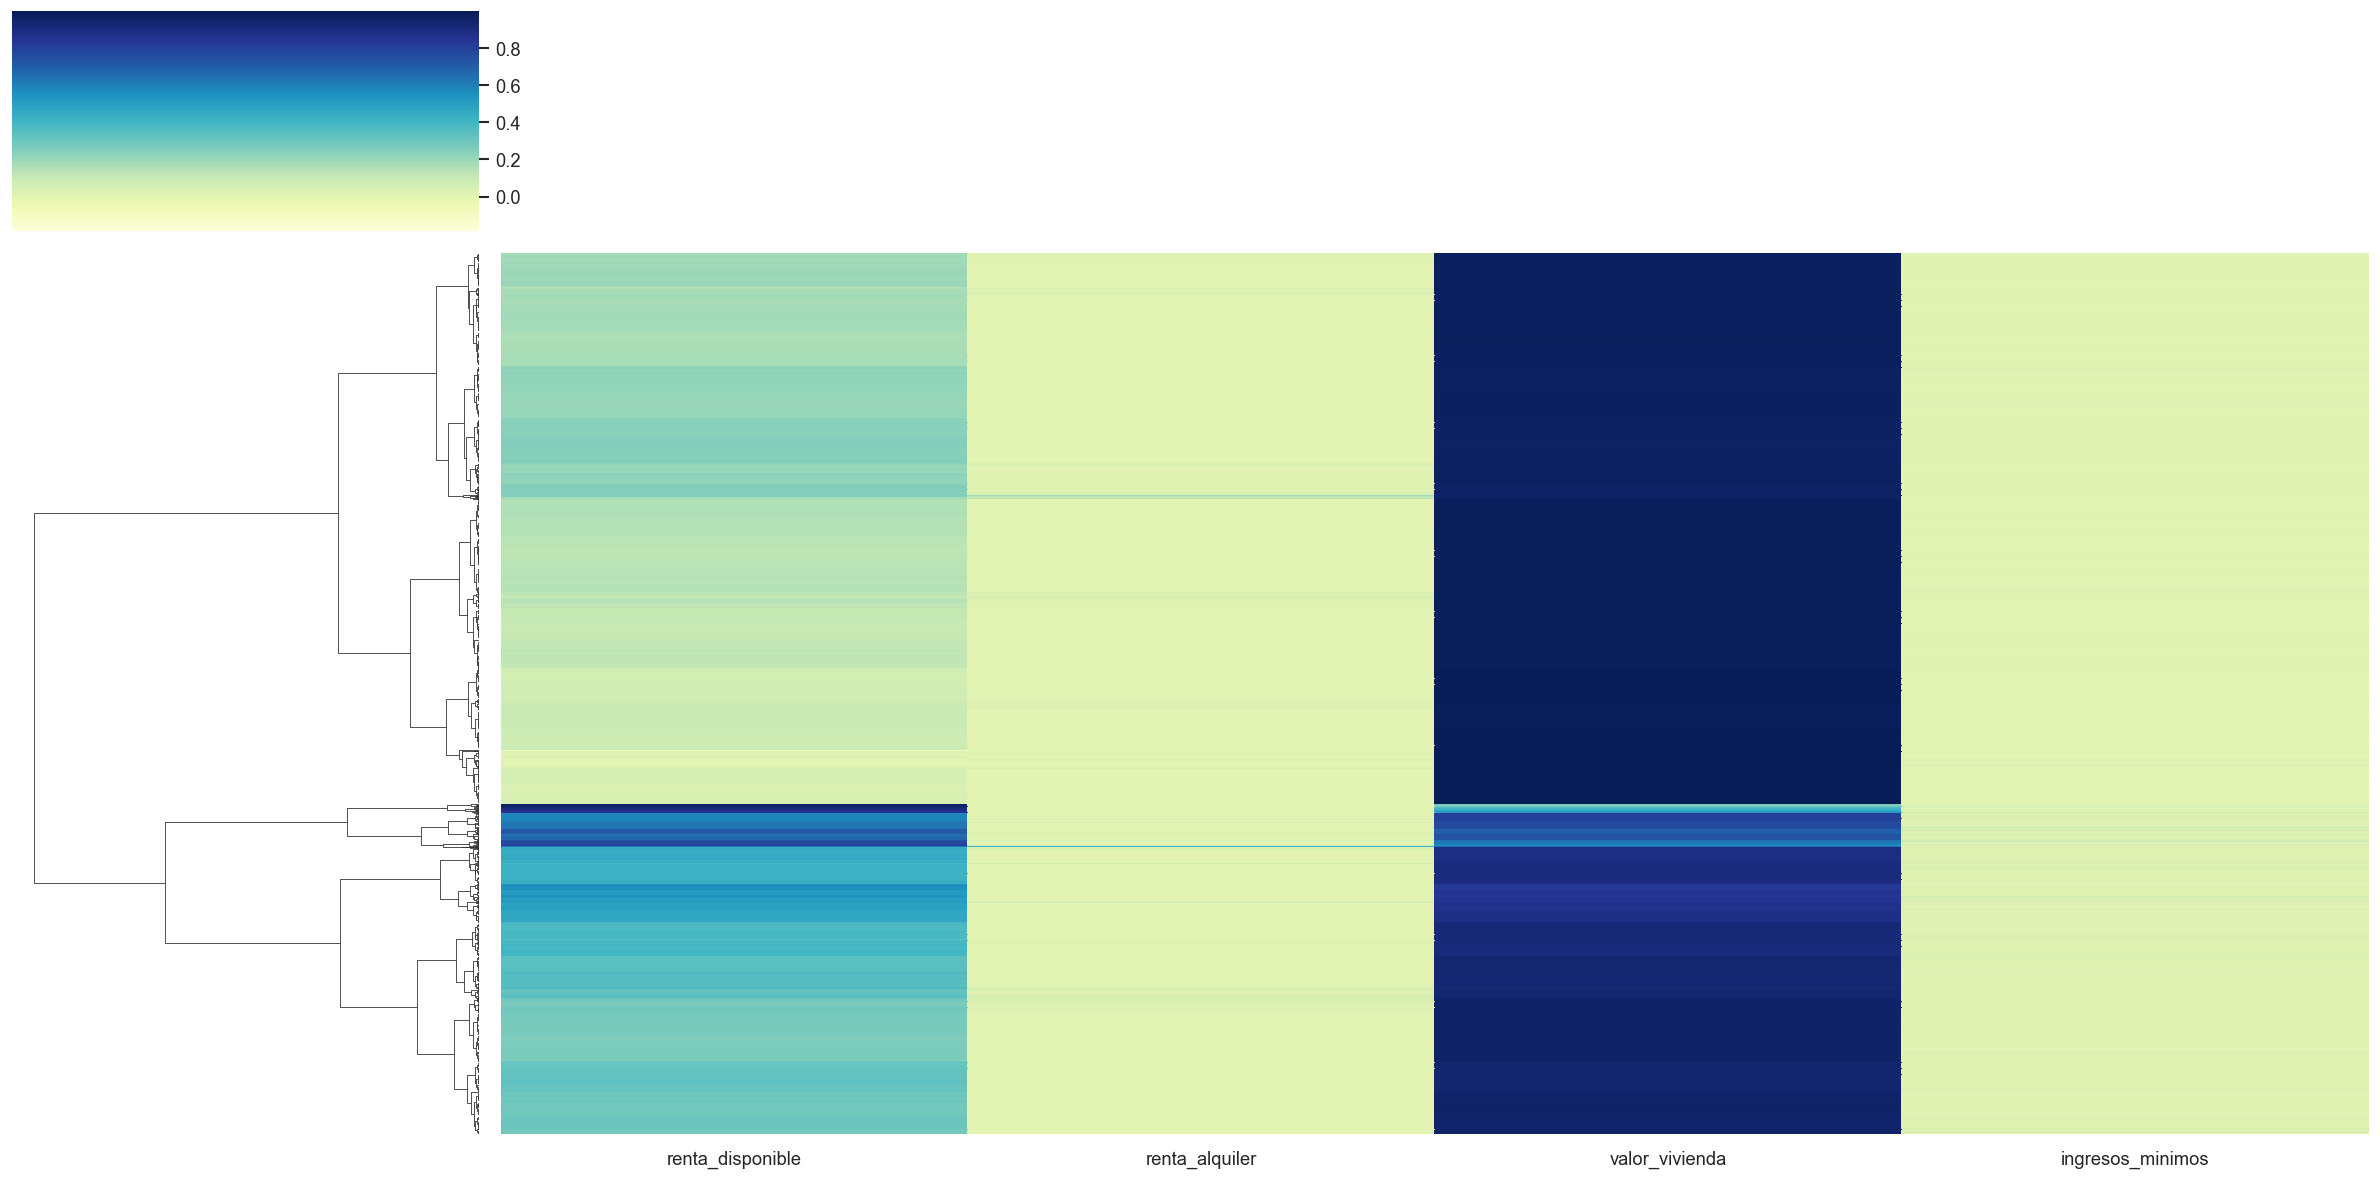

<Figure size 720x480 with 0 Axes>

In [46]:
visualization.plot_dendrogram_heat(algorithms[4].instances[0])

### Análisis K-Means

In [160]:
kmeans_ch = pd.DataFrame(columns=case.columns)
kmeans_X_clusters = algorithms[0].instances[0]['X_clusters']
for cluster in algorithms[0].instances[0]['cluster_ids']:
    quantiles = kmeans_X_clusters[kmeans_X_clusters['cluster']==cluster].quantile([.25, .75])
    d = {}
    for col in case.columns:
        d[col] = f"{quantiles.loc[.25][col]:.2f}-{quantiles.loc[.75][col]:.2f}"
    kmeans_ch.loc[cluster] = d
print(kmeans_ch.to_latex())

\begin{tabular}{lllll}
\toprule
{} &    renta\_disponible &     renta\_alquiler &       valor\_vivienda & ingresos\_minimos \\
\midrule
0 &   17101.62-31076.06 &          0.00-0.00 &   80000.00-200000.00 &  1200.00-2000.00 \\
1 &   43558.43-59761.70 &       0.00-1503.20 &  140000.00-300000.00 &  2000.00-3000.00 \\
2 &   35820.50-64613.50 &   9915.40-17908.80 &  240000.00-550000.00 &  2000.00-3000.00 \\
3 &  82654.40-110829.30 &       0.00-3642.35 &  240000.00-500000.00 &  2000.00-4000.00 \\
4 &  68053.10-157629.30 &  44135.40-66250.00 &  175000.00-675000.00 &  1800.00-4750.00 \\
\bottomrule
\end{tabular}



In [47]:
kmeans = ClusterAlgorithm(KMeans, name='K-Means', centroid_attr='cluster_centers_', not_instantiate=True)

In [48]:
kmeans.add_instances_product({
    'init': ['k-means++'],
    'n_clusters': range(2, 20),
    'n_init': [5],
    'random_state': [common.RANDOM_SEED],
})

['k-means++'] range(2, 20) [5] [19122000]


In [49]:
kmeans

<ClusterAlgorithm [K-Means], 18 instances:
	init=k-means++, n_clusters=2, n_init=5, random_state=19122000;
	init=k-means++, n_clusters=3, n_init=5, random_state=19122000;
	init=k-means++, n_clusters=4, n_init=5, random_state=19122000;
	init=k-means++, n_clusters=5, n_init=5, random_state=19122000;
	init=k-means++, n_clusters=6, n_init=5, random_state=19122000;
	init=k-means++, n_clusters=7, n_init=5, random_state=19122000;
	init=k-means++, n_clusters=8, n_init=5, random_state=19122000;
	init=k-means++, n_clusters=9, n_init=5, random_state=19122000;
	init=k-means++, n_clusters=10, n_init=5, random_state=19122000;
	init=k-means++, n_clusters=11, n_init=5, random_state=19122000;
	init=k-means++, n_clusters=12, n_init=5, random_state=19122000;
	init=k-means++, n_clusters=13, n_init=5, random_state=19122000;
	init=k-means++, n_clusters=14, n_init=5, random_state=19122000;
	init=k-means++, n_clusters=15, n_init=5, random_state=19122000;
	init=k-means++, n_clusters=16, n_init=5, random_state=

In [50]:
kmeans.run_instances(case, verbose=True)

[K-Means] Running instance init=k-means++, n_clusters=2, n_init=5, random_state=19122000...
[K-Means] Running instance init=k-means++, n_clusters=3, n_init=5, random_state=19122000...
[K-Means] Running instance init=k-means++, n_clusters=4, n_init=5, random_state=19122000...
[K-Means] Running instance init=k-means++, n_clusters=5, n_init=5, random_state=19122000...
[K-Means] Running instance init=k-means++, n_clusters=6, n_init=5, random_state=19122000...
[K-Means] Running instance init=k-means++, n_clusters=7, n_init=5, random_state=19122000...
[K-Means] Running instance init=k-means++, n_clusters=8, n_init=5, random_state=19122000...
[K-Means] Running instance init=k-means++, n_clusters=9, n_init=5, random_state=19122000...
[K-Means] Running instance init=k-means++, n_clusters=10, n_init=5, random_state=19122000...
[K-Means] Running instance init=k-means++, n_clusters=11, n_init=5, random_state=19122000...
[K-Means] Running instance init=k-means++, n_clusters=12, n_init=5, random_sta

In [51]:
kmeans.calculate_metrics(cluster.metrics, verbose=True)

[K-Means] Calculating metrics in instance init=k-means++, n_clusters=2, n_init=5, random_state=19122000...
[K-Means] Calculating metrics in instance init=k-means++, n_clusters=3, n_init=5, random_state=19122000...
[K-Means] Calculating metrics in instance init=k-means++, n_clusters=4, n_init=5, random_state=19122000...
[K-Means] Calculating metrics in instance init=k-means++, n_clusters=5, n_init=5, random_state=19122000...
[K-Means] Calculating metrics in instance init=k-means++, n_clusters=6, n_init=5, random_state=19122000...
[K-Means] Calculating metrics in instance init=k-means++, n_clusters=7, n_init=5, random_state=19122000...
[K-Means] Calculating metrics in instance init=k-means++, n_clusters=8, n_init=5, random_state=19122000...
[K-Means] Calculating metrics in instance init=k-means++, n_clusters=9, n_init=5, random_state=19122000...
[K-Means] Calculating metrics in instance init=k-means++, n_clusters=10, n_init=5, random_state=19122000...
[K-Means] Calculating metrics in ins

In [52]:
kmeans_metrics = pd.DataFrame(columns=cluster.metrics.keys())
for i, instance in enumerate(kmeans.instances):
    kmeans_metrics.loc[i] = instance['metrics']
kmeans_metrics

,Tiempo,Calinski-Harabasz,Davies-Bouldin,Silhouette,Número de clusters
0,0.061098,1345.565635,1.152314,0.456152,2
1,0.080203,1232.139117,1.007142,0.426158,3
2,0.115737,1130.660402,1.121137,0.340508,4
3,0.098984,1085.753364,1.059004,0.347075,5
4,0.156956,1042.253236,1.122265,0.362850,6
5,0.126228,1056.085317,1.032087,0.283777,7
6,0.152088,994.188695,0.840355,0.315441,8
7,0.172081,1016.257963,0.844853,0.288534,9
8,0.159073,1008.070906,0.892231,0.243434,10
9,0.205697,1017.990642,0.944936,0.256908,11


<AxesSubplot:xlabel='Número de clusters', ylabel='Calinski-Harabasz'>

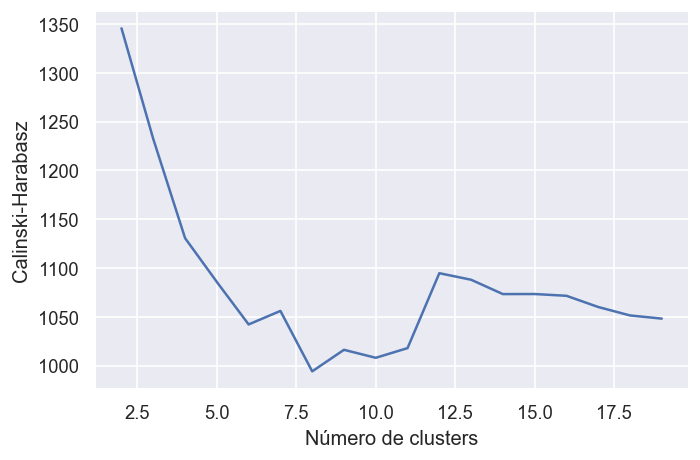

In [53]:
sns.lineplot(data=kmeans_metrics, x="Número de clusters", y="Calinski-Harabasz")

<AxesSubplot:xlabel='Número de clusters', ylabel='Davies-Bouldin'>

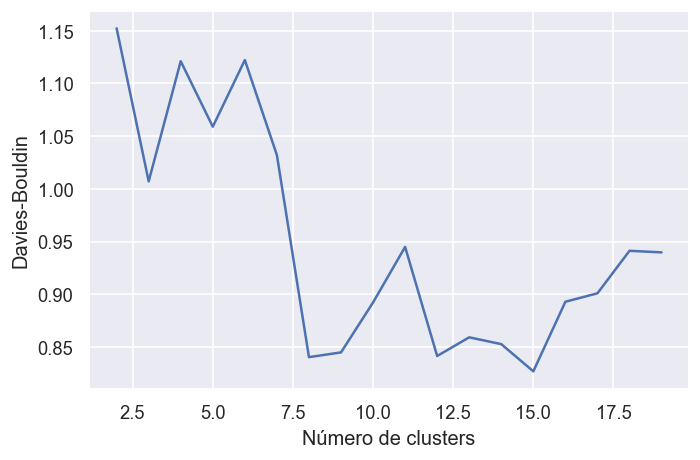

In [54]:
sns.lineplot(data=kmeans_metrics, x="Número de clusters", y="Davies-Bouldin")

<AxesSubplot:xlabel='Número de clusters', ylabel='Silhouette'>

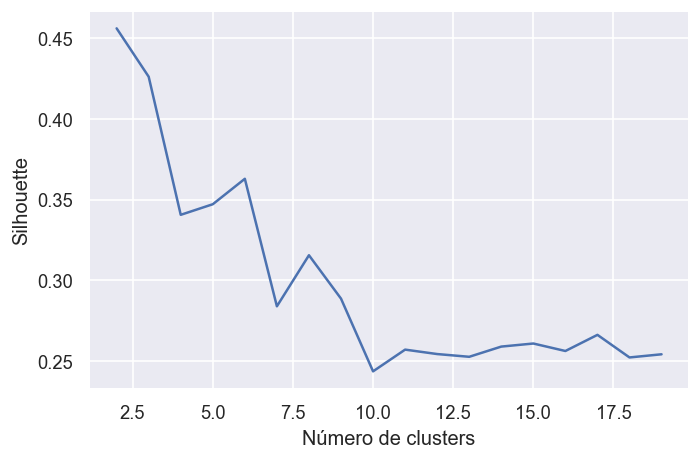

In [55]:
sns.lineplot(data=kmeans_metrics, x="Número de clusters", y="Silhouette")

### Análisis DBSCAN

In [164]:
dbscan_ch = pd.DataFrame(columns=case.columns)
dbscan_X_clusters = algorithms[2].instances[0]['X_clusters']
for cluster in algorithms[2].instances[0]['cluster_ids']:
    quantiles = dbscan_X_clusters[dbscan_X_clusters['cluster']==cluster].quantile([.25, .75])
    d = {}
    for col in case.columns:
        d[col] = f"{quantiles.loc[.25][col]:.2f}-{quantiles.loc[.75][col]:.2f}"
    dbscan_ch.loc[cluster] = d
dbscan_ch

,renta_disponible,renta_alquiler,valor_vivienda,ingresos_minimos
-1,28743.35-65921.25,0.00-3496.00,150000.00-350000.00,1500.00-3000.00
0,19817.95-36794.05,0.00-0.00,80000.00-180000.00,1290.00-2000.00
1,44362.70-46499.35,0.00-0.00,115000.00-181500.00,2500.00-2500.00
2,53186.38-59742.97,0.00-0.00,150000.00-200000.00,3000.00-3000.00
3,36885.55-45019.35,0.00-0.00,120000.00-182500.00,3000.00-3000.00


In [97]:
dbscan = ClusterAlgorithm(DBSCAN, name='DBSCAN', not_instantiate=True)

In [98]:
dbscan.add_instances_product({
    'eps': [.01, .025, .05, .1, .15, .2, .25, .3],
    'min_samples': range(5, 25, 5),
})

[0.01, 0.025, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3] range(5, 25, 5)


In [99]:
dbscan

<ClusterAlgorithm [DBSCAN], 32 instances:
	eps=0.01, min_samples=5;
	eps=0.01, min_samples=10;
	eps=0.01, min_samples=15;
	eps=0.01, min_samples=20;
	eps=0.025, min_samples=5;
	eps=0.025, min_samples=10;
	eps=0.025, min_samples=15;
	eps=0.025, min_samples=20;
	eps=0.05, min_samples=5;
	eps=0.05, min_samples=10;
	eps=0.05, min_samples=15;
	eps=0.05, min_samples=20;
	eps=0.1, min_samples=5;
	eps=0.1, min_samples=10;
	eps=0.1, min_samples=15;
	eps=0.1, min_samples=20;
	eps=0.15, min_samples=5;
	eps=0.15, min_samples=10;
	eps=0.15, min_samples=15;
	eps=0.15, min_samples=20;
	eps=0.2, min_samples=5;
	eps=0.2, min_samples=10;
	eps=0.2, min_samples=15;
	eps=0.2, min_samples=20;
	eps=0.25, min_samples=5;
	eps=0.25, min_samples=10;
	eps=0.25, min_samples=15;
	eps=0.25, min_samples=20;
	eps=0.3, min_samples=5;
	eps=0.3, min_samples=10;
	eps=0.3, min_samples=15;
	eps=0.3, min_samples=20>

In [100]:
dbscan.run_instances(case, verbose=True)

[DBSCAN] Running instance eps=0.01, min_samples=5...
[DBSCAN] Running instance eps=0.01, min_samples=10...
[DBSCAN] Running instance eps=0.01, min_samples=15...
[DBSCAN] Running instance eps=0.01, min_samples=20...
[DBSCAN] Running instance eps=0.025, min_samples=5...
[DBSCAN] Running instance eps=0.025, min_samples=10...
[DBSCAN] Running instance eps=0.025, min_samples=15...
[DBSCAN] Running instance eps=0.025, min_samples=20...
[DBSCAN] Running instance eps=0.05, min_samples=5...
[DBSCAN] Running instance eps=0.05, min_samples=10...
[DBSCAN] Running instance eps=0.05, min_samples=15...
[DBSCAN] Running instance eps=0.05, min_samples=20...
[DBSCAN] Running instance eps=0.1, min_samples=5...
[DBSCAN] Running instance eps=0.1, min_samples=10...
[DBSCAN] Running instance eps=0.1, min_samples=15...
[DBSCAN] Running instance eps=0.1, min_samples=20...
[DBSCAN] Running instance eps=0.15, min_samples=5...
[DBSCAN] Running instance eps=0.15, min_samples=10...
[DBSCAN] Running instance eps=0.1

In [101]:
dbscan.calculate_metrics(cluster.metrics, verbose=True)

[DBSCAN] Calculating metrics in instance eps=0.01, min_samples=5...
[DBSCAN] Calculating metrics in instance eps=0.01, min_samples=10...
[DBSCAN] Calculating metrics in instance eps=0.01, min_samples=15...
[DBSCAN] Calculating metrics in instance eps=0.01, min_samples=20...
[DBSCAN] Calculating metrics in instance eps=0.025, min_samples=5...
[DBSCAN] Calculating metrics in instance eps=0.025, min_samples=10...
[DBSCAN] Calculating metrics in instance eps=0.025, min_samples=15...
[DBSCAN] Calculating metrics in instance eps=0.025, min_samples=20...
[DBSCAN] Calculating metrics in instance eps=0.05, min_samples=5...
[DBSCAN] Calculating metrics in instance eps=0.05, min_samples=10...
[DBSCAN] Calculating metrics in instance eps=0.05, min_samples=15...
[DBSCAN] Calculating metrics in instance eps=0.05, min_samples=20...
[DBSCAN] Calculating metrics in instance eps=0.1, min_samples=5...
[DBSCAN] Calculating metrics in instance eps=0.1, min_samples=10...
[DBSCAN] Calculating metrics in inst

In [125]:
dbscan_metrics = pd.DataFrame(columns=['Epsilon', 'Mínimo de samples'] + list(cluster.metrics.keys()))
for i, instance in enumerate(dbscan.instances):
    d = instance['metrics']
    d['Epsilon'], d['Mínimo de samples'] = instance['instance_values']['eps'], instance['instance_values']['min_samples']
    dbscan_metrics.loc[i] = d
dbscan_metrics['Número de clusters'] = dbscan_metrics['Número de clusters'].astype(str).astype(int)
dbscan_metrics

,Epsilon,Mínimo de samples,Tiempo,Calinski-Harabasz,Davies-Bouldin,Silhouette,Número de clusters
0,0.010,5,0.057119,37.714815,1.929662,-0.441902,17
1,0.010,10,0.044803,284.761368,2.276998,0.027153,3
2,0.010,15,0.040622,133.877231,2.149241,-0.134353,5
3,0.010,20,0.042163,98.963152,1.984486,-0.185535,6
4,0.025,5,0.084432,370.283688,1.620323,0.398102,3
5,0.025,10,0.083957,788.209068,1.562690,0.517122,2
6,0.025,15,0.087013,791.534490,1.573986,0.486548,2
7,0.025,20,0.081952,786.720871,1.596716,0.461422,2
8,0.050,5,0.160941,232.880642,1.838346,0.600787,4
9,0.050,10,0.168896,691.101831,1.387485,0.703619,2


<AxesSubplot:xlabel='Mínimo de samples', ylabel='Calinski-Harabasz'>

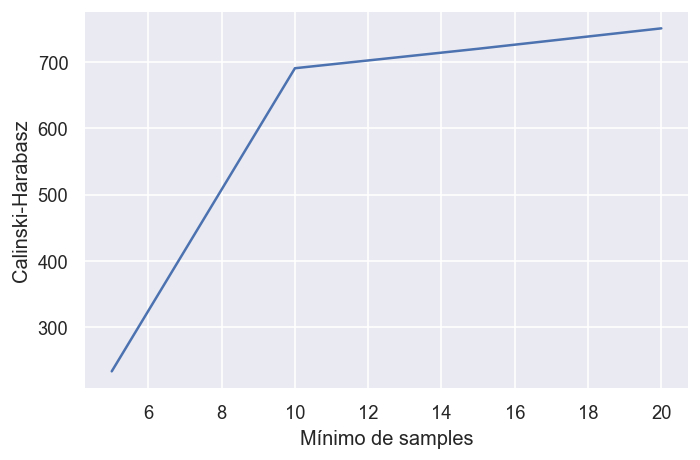

In [174]:
# fijado eps=.1
sns.lineplot(data=dbscan_metrics[dbscan_metrics['Epsilon']==.05], x="Mínimo de samples", y="Calinski-Harabasz")

<AxesSubplot:xlabel='Mínimo de samples', ylabel='Davies-Bouldin'>

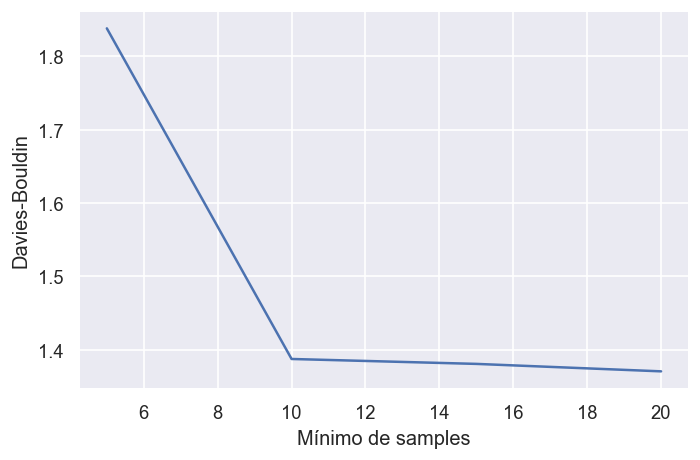

In [173]:
# fijado eps=.1
sns.lineplot(data=dbscan_metrics[dbscan_metrics['Epsilon']==.05], x="Mínimo de samples", y="Davies-Bouldin")

<AxesSubplot:xlabel='Mínimo de samples', ylabel='Silhouette'>

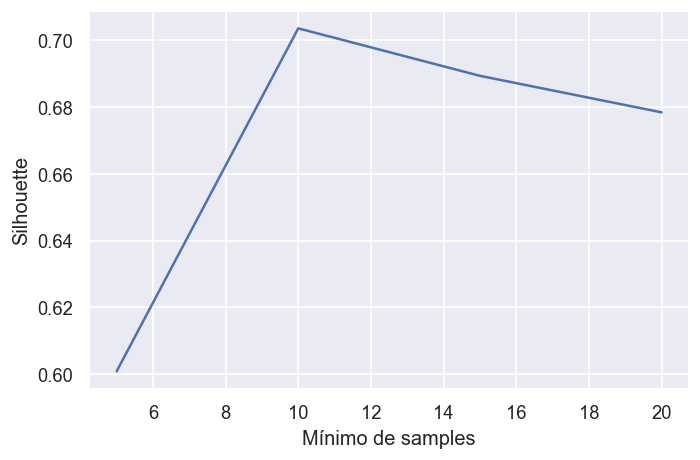

In [172]:
# fijado eps=.01
sns.lineplot(data=dbscan_metrics[dbscan_metrics['Epsilon']==.05], x="Mínimo de samples", y="Silhouette")

<AxesSubplot:xlabel='Mínimo de samples', ylabel='Número de clusters'>

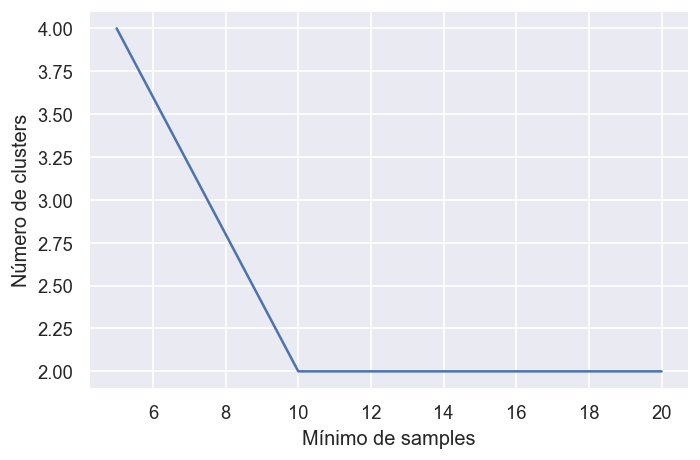

In [171]:
# fijado eps=.01
sns.lineplot(data=dbscan_metrics[dbscan_metrics['Epsilon']==.05], x="Mínimo de samples", y="Número de clusters")

<AxesSubplot:xlabel='Epsilon', ylabel='Calinski-Harabasz'>

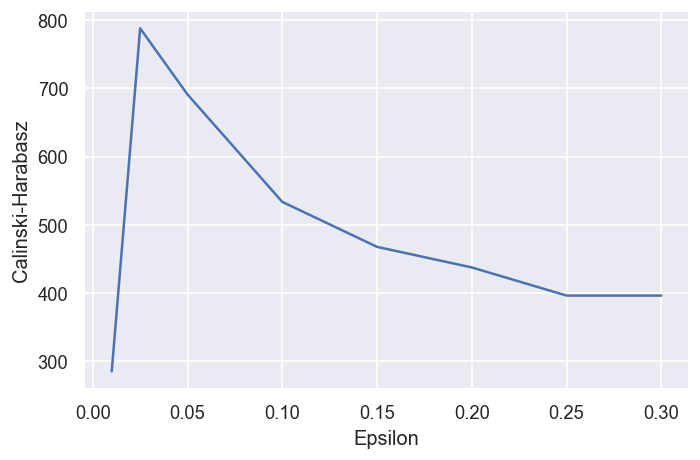

In [130]:
# fijado min_samples=10
sns.lineplot(data=dbscan_metrics[dbscan_metrics['Mínimo de samples']==10], x="Epsilon", y="Calinski-Harabasz")

<AxesSubplot:xlabel='Epsilon', ylabel='Davies-Bouldin'>

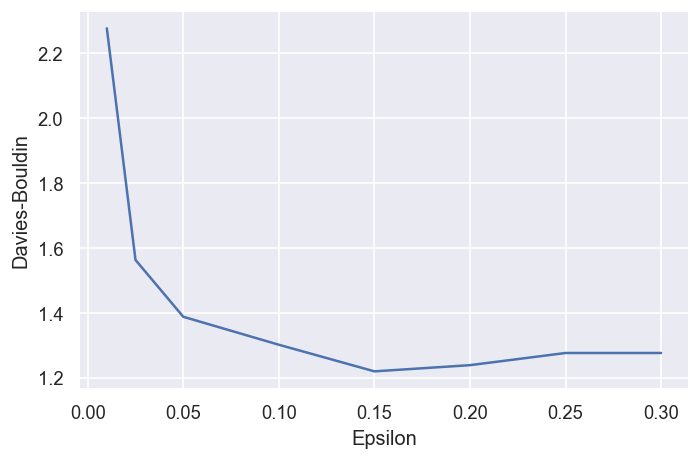

In [131]:
# fijado min_samples=10
sns.lineplot(data=dbscan_metrics[dbscan_metrics['Mínimo de samples']==10], x="Epsilon", y="Davies-Bouldin")

<AxesSubplot:xlabel='Epsilon', ylabel='Silhouette'>

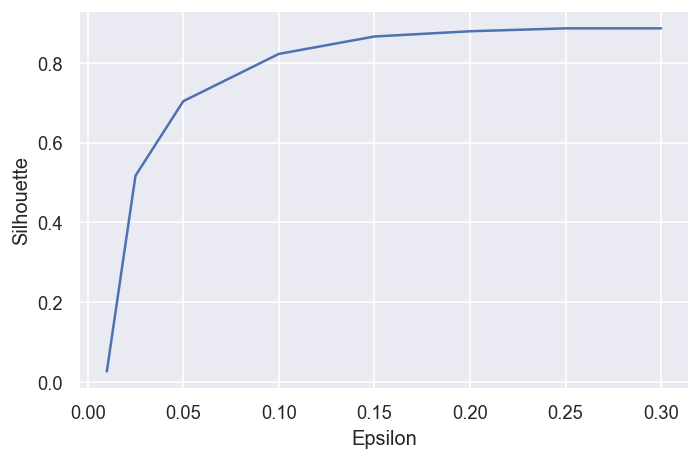

In [132]:
# fijado min_samples=10
sns.lineplot(data=dbscan_metrics[dbscan_metrics['Mínimo de samples']==10], x="Epsilon", y="Silhouette")

<AxesSubplot:xlabel='Epsilon', ylabel='Número de clusters'>

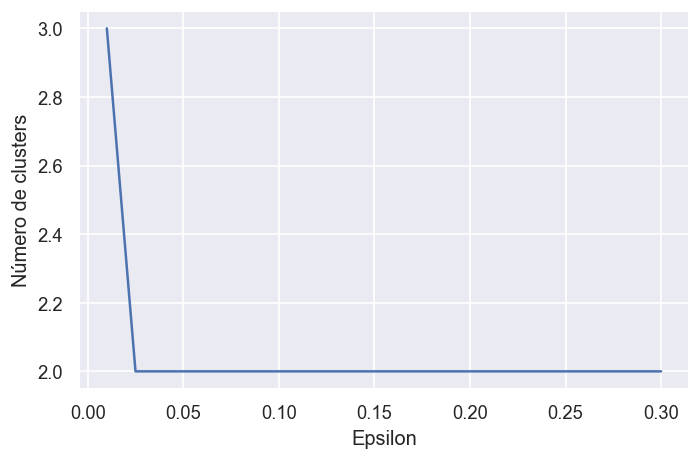

In [133]:
# fijado min_samples=10
sns.lineplot(data=dbscan_metrics[dbscan_metrics['Mínimo de samples']==10], x="Epsilon", y="Número de clusters")